IMPORTING LIBRARIES

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import keras as ks
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau




2024-12-28 15:20:17.526134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Visualise 5 random samples

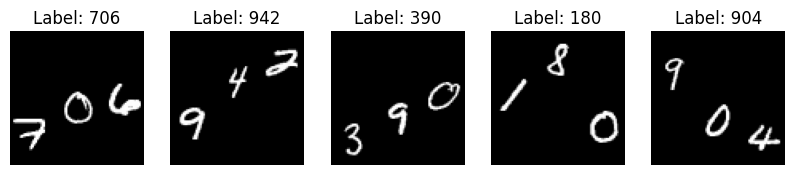

In [2]:
#init image database path
db_path='./triple_mnist/'
db_sets=['val/','train/','test/']

#init images array
imgs=[]

for i in range(5):
    db_set=random.choice(db_sets)

    #combine set with db path
    set_path=db_path+db_set

    #create list of all subfolders in set
    sub_folders=os.listdir(set_path)

    #select random subfolder and get pathname
    subfolder=random.choice(sub_folders)
    subfolder_path = os.path.join(set_path, subfolder)

    #select random image and get pathname
    img=random.choice(os.listdir(subfolder_path))
    img_path=os.path.join(subfolder_path, img)

    #open image and add to array
    img=Image.open(img_path)
    imgs.append((img, subfolder))

#display images using matplotlib
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(imgs, start=1):
    plt.subplot(1, len(imgs), i)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

Visualise 5 samples with same label

In [ ]:
#init images array
imgs=[]
db_sets=['val/','train/','test/']

db_set=random.choice(db_sets)

#combine set with db path
set_path=db_path+db_set

#create list of all subfolders in set
sub_folders=os.listdir(set_path)

#select random subfolder and get pathname
subfolder=random.choice(sub_folders)
subfolder_path = os.path.join(set_path, subfolder)

for i in range(5):
    #select random image and get pathname
    img=random.choice(os.listdir(subfolder_path))
    img_path=os.path.join(subfolder_path, img)

    #open image and add to array
    img=Image.open(img_path)
    imgs.append((img, subfolder))

#display images using matplotlib
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(imgs, start=1):
    plt.subplot(1, len(imgs), i)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

Proof of uniform class distribution

In [4]:
db_path='./triple_mnist/'
label_total = 0

for set in os.listdir(db_path):
    set_path=db_path+set
    for label in os.listdir(set_path):
        subfolder_path = os.path.join(set_path, label)
        if len(os.listdir(subfolder_path)) == 100:
            label_total+=1

print(label_total)


1000


img to array (45 x 45)

In [5]:
db_path='./triple_mnist/'

def flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            flattened_img = (Image.open(img_path)).resize((45, 45))
            flattened_img = (np.array((flattened_img).convert('L')))

            imgs.append(flattened_img)
            labels.append(int(folder))



    return np.array(imgs), np.array(labels)


train_imgs, train_labels = flatten_toarray('train')
test_imgs, test_labels = flatten_toarray('test')
val_imgs, val_labels = flatten_toarray('val')

train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0
val_imgs = val_imgs / 255.0

img to array (84x84)

In [8]:
db_path='./triple_mnist/'

def flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            flattened_img = (Image.open(img_path))
            flattened_img = (np.array((flattened_img).convert('L')))

            imgs.append(flattened_img)
            labels.append(int(folder))
            
    return np.array(imgs), np.array(labels)


f_train_imgs, f_train_labels = flatten_toarray('train')
f_test_imgs, f_test_labels = flatten_toarray('test')
f_val_imgs, f_val_labels = flatten_toarray('val')

f_train_imgs = f_train_imgs / 255.0
f_test_imgs = f_test_imgs / 255.0
f_val_imgs = f_val_imgs / 255.0

In [166]:
print(f"img shape : {f_train_imgs.shape}")

print(f"label shape : {f_train_labels.shape}")

img shape : (64000, 84, 84)
label shape : (64000,)


combine all splits

In [7]:
all_imgs = np.vstack(((train_imgs, test_imgs, val_imgs)))
all_labels = np.vstack(((train_labels.reshape(train_labels.shape[0], -1), test_labels.reshape(test_labels.shape[0], -1),val_labels.reshape(val_labels.shape[0], -1))))

make seperate splits

In [8]:
sp_train_imgs, sp_test_imgs, sp_train_labels, sp_test_labels = train_test_split(
    all_imgs, all_labels, test_size=0.2, random_state=42
)

sp_train_imgs, sp_val_imgs, sp_train_labels, sp_val_labels = train_test_split(
    sp_train_imgs, sp_train_labels, test_size=0.25, random_state=42
) 

print(f"Training set size: {train_imgs.shape[0]}")
print(f"Validation set size: {val_imgs.shape[0]}")
print(f"Test set size: {test_imgs.shape[0]}")

Training set size: 64000
Validation set size: 16000
Test set size: 20000


Logistic regression with new splits

In [9]:
sp_log_reg = LogisticRegression(max_iter=1000)

sp_log_reg.fit(sp_train_imgs.reshape(sp_train_imgs.shape[0], -1), sp_train_labels)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

logistic regression model with seperate splits

In [10]:
log_reg2 = LogisticRegression(max_iter=1000, C=0.1)

log_reg2.fit(train_imgs.reshape(train_imgs.shape[0], -1), train_labels)

LogisticRegression(C=0.1, max_iter=1000)

In [11]:
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(train_imgs.reshape(train_imgs.shape[0], -1), train_labels)

LogisticRegression(max_iter=1000)

In [12]:
# Reshape the test images to match the input format of the model
test_imgs_reshaped = test_imgs.reshape(test_imgs.shape[0], -1)
sp_test_imgs_reshaped = sp_test_imgs.reshape(sp_test_imgs.shape[0], -1)


# Predict the labels for the test data
test_pred = log_reg.predict(test_imgs_reshaped)
test_pred2 = log_reg2.predict(test_imgs_reshaped)
sp_test_pred = sp_log_reg.predict(sp_test_imgs_reshaped)


In [13]:
def get_accuracy(model):
        # Evaluate the model on the training set
        train_score = model.score(train_imgs.reshape(train_imgs.shape[0], -1), train_labels)
        print(f'Training Accuracy: {train_score:.4f}')

        # Evaluate the model on the validation set
        val_score = model.score(val_imgs.reshape(val_imgs.shape[0], -1), val_labels)
        print(f'Validation Accuracy: {val_score:.4f}')

        # Evaluate the model on the test set
        test_score = model.score(test_imgs.reshape(test_imgs.shape[0], -1), test_labels)
        print(f'Test Accuracy: {test_score:.4f}')
def sp_get_accuracy(model):
        # Evaluate the model on the training set
        sp_train_score = model.score(sp_train_imgs.reshape(sp_train_imgs.shape[0], -1), sp_train_labels)
        print(f'Training Accuracy: {sp_train_score:.4f}')

        # Evaluate the model on the validation set
        sp_val_score = model.score(sp_val_imgs.reshape(sp_val_imgs.shape[0], -1), sp_val_labels)
        print(f'Validation Accuracy: {sp_val_score:.4f}')

        # Evaluate the model on the test set
        sp_test_score = model.score(sp_test_imgs.reshape(sp_test_imgs.shape[0], -1), sp_test_labels)
        print(f'Test Accuracy: {sp_test_score:.4f}')

In [14]:
get_accuracy(log_reg)
print("\n\n")
get_accuracy(log_reg2)
print("\n\n")
sp_get_accuracy(sp_log_reg)

Training Accuracy: 0.8231
Validation Accuracy: 0.0000
Test Accuracy: 0.0000



Training Accuracy: 0.4036
Validation Accuracy: 0.0000
Test Accuracy: 0.0000



Training Accuracy: 0.9497
Validation Accuracy: 0.0296
Test Accuracy: 0.0317


In [15]:
# Convert multi-class predictions to binary (positive = class '0')
def convert_to_binary(predictions, target_class=0):
    return (predictions == target_class).astype(int)

def get_conf_matrix(_test_pred, _test_labels):

    binary_test_pred = convert_to_binary(_test_pred, target_class=0)
    binary_test_labels = convert_to_binary(_test_labels, target_class=0)

    # Generate confusion matrix (binary)
    conf_matrix = confusion_matrix(binary_test_labels, np.ones_like(binary_test_pred))

    # Extract TP, FP, TN, FN
    TP, FP, FN, TN = conf_matrix.ravel()

    # Print the confusion matrix details
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Negatives (FN): {FN}")

    # Calculate accuracy and other metrics
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Binary Confusion Matrix')
    plt.show()

True Positives (TP): 0
False Positives (FP): 19980
True Negatives (TN): 20
False Negatives (FN): 0
Accuracy: 0.0010
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


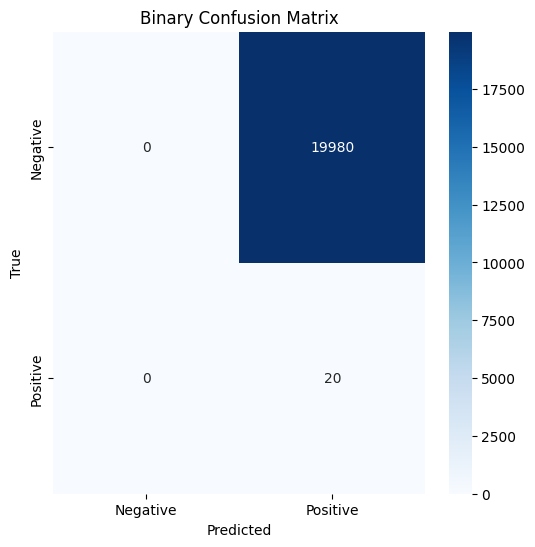

In [16]:
get_conf_matrix(sp_test_pred, sp_test_labels)

In [17]:
print("Values present in both train & test labels:", len(np.intersect1d(test_labels, train_labels)))

print("Values present in both train & test labels with new splits:", len(np.intersect1d(sp_test_labels, sp_train_labels)))

Values present in both train & test labels: 0
Values present in both train & test labels with new splits: 1000


In [18]:
# Count the occurrences of each label in sp_test_labels
unique_labels, label_counts = np.unique(sp_train_labels, return_counts=True)

# Calculate the average number of samples per label
average_samples_per_label = np.mean(label_counts)

# Display the results
print(f"Average number of samples per label in sp_test_labels: {average_samples_per_label:.2f}")

Average number of samples per label in sp_test_labels: 60.00


In [19]:
unique_count_test = len(np.unique(test_labels))

unique_count_train = len(np.unique(train_labels))

# Display the results
print(f"Number of unique labels in sp_test_labels: {unique_count_test}")
print(f"Number of unique labels in sp_train_labels: {unique_count_train}")

Number of unique labels in sp_test_labels: 200
Number of unique labels in sp_train_labels: 640


In [20]:
print(len(train_imgs))

64000


In [21]:
def check_val(value, train, test):
    value_to_check = value  

    count_in_train = np.count_nonzero(train == value_to_check)
    count_in_test = np.count_nonzero(test == value_to_check)

    print(f"The value {value_to_check} appears {count_in_train} time(s) in the train data.")
    print(f"The value {value_to_check} appears {count_in_test} time(s) in the test data.")


In [22]:
def show_label_preds(true_false, original_images, y_true, y_pred, num_samples=25):
    try:
        y_pred = np.argmax(y_pred, axis=1)
    except Exception as e:
        pass

    if (true_false):
        indices = np.where((test_labels == y_pred))[0]
        title = "Correct Preditions"
    else:
        indices = np.where((test_labels != y_pred))[0]
        title = "Incorrect Preditions"

    # for n in indices:
    #     print(f"{y_true[n]} : {y_pred[n]}")
    
    if len(indices) > num_samples:
        sample_indices = np.random.choice(indices, num_samples, replace=False)
    else:
        sample_indices = indices
    
    grid_size = int(np.ceil(np.sqrt(len(sample_indices))))
    
    plt.figure(figsize=(20, 20))
    for idx, i in enumerate(sample_indices):
        plt.subplot(grid_size, grid_size, idx + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title(f'True: {y_true[i]}\nPred: {y_pred[i]}')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


TASK 2 CNN

In [23]:
sp_cnn_train_imgs = sp_train_imgs[:, :, :, np.newaxis]
sp_cnn_val_imgs = sp_val_imgs[:, :, :, np.newaxis]
sp_cnn_test_imgs = sp_test_imgs[:, :, :, np.newaxis]

'''
print(f"cnn_train_imgs shape: {sp_cnn_train_imgs.shape}")
print(f"cnn_test_imgs shape: {sp_cnn_val_imgs.shape}")
print(sp_train_labels.shape)
print(sp_val_labels.shape)
print(len(sp_train_labels))
'''

'\nprint(f"cnn_train_imgs shape: {sp_cnn_train_imgs.shape}")\nprint(f"cnn_test_imgs shape: {sp_cnn_val_imgs.shape}")\nprint(sp_train_labels.shape)\nprint(sp_val_labels.shape)\nprint(len(sp_train_labels))\n'

In [24]:
cnn_train_imgs = train_imgs[:, :, :, np.newaxis]
cnn_val_imgs = val_imgs[:, :, :, np.newaxis]
cnn_test_imgs = test_imgs[:, :, :, np.newaxis]
'''
print(f"cnn_train_imgs shape: {cnn_train_imgs.shape}")
print(f"cnn_test_imgs shape: {cnn_val_imgs.shape}")
print(train_labels.shape)
print(val_labels.shape)
print(len(train_labels))
'''

'\nprint(f"cnn_train_imgs shape: {cnn_train_imgs.shape}")\nprint(f"cnn_test_imgs shape: {cnn_val_imgs.shape}")\nprint(train_labels.shape)\nprint(val_labels.shape)\nprint(len(train_labels))\n'

In [25]:
def build_cnn_basic():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 45, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(1000, activation='softmax'))

    return model

In [26]:
def build_cnn_comp():
    model2 = models.Sequential()

    model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 45, 1)))
    model2.add(layers.BatchNormalization())
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Dropout(0.3))

    model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Dropout(0.3))

    model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Dropout(0.3))

    model2.add(layers.Flatten())

    model2.add(layers.Dense(512, activation='relu'))
    model2.add(layers.Dropout(0.5))

    model2.add(layers.Dense(1000, activation='softmax')) 

    return model2

In [27]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [28]:
model1 = build_cnn_basic()

model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history1 = model1.fit(cnn_train_imgs, train_labels, epochs=50, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels),
              callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
1000/1000 [==============================] - 48s 47ms/step - loss: 5.6583 - accuracy: 0.0297 - val_loss: 24.1020 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - 49s 49ms/step - loss: 3.2790 - accuracy: 0.2087 - val_loss: 30.5273 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
1000/1000 [==============================] - 49s 49ms/step - loss: 2.3531 - accuracy: 0.3700 - val_loss: 32.3742 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/50
1000/1000 [==============================] - 50s 50ms/step - loss: 1.9164 - accuracy: 0.4679 - val_loss: 33.2662 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/50
1000/1000 [==============================] - 51s 51ms/step - loss: 1.6318 - accuracy: 0.5358 - val_loss: 33.3398 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/50
1000/1000 [==============================] - 50s 50ms/step - loss: 1.4300 - accuracy: 0.5849 - val_loss: 34.2990 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/50
1000/

In [29]:
model_1 = build_cnn_basic()

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history_1 = model_1.fit(cnn_train_imgs, train_labels, epochs=50, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels),
              callbacks=[early_stopping])

Epoch 1/50
1000/1000 [==============================] - 46s 46ms/step - loss: 5.5920 - accuracy: 0.0323 - val_loss: 25.3168 - val_accuracy: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 49s 49ms/step - loss: 3.1832 - accuracy: 0.2220 - val_loss: 32.2795 - val_accuracy: 0.0000e+00
Epoch 3/50
1000/1000 [==============================] - 47s 47ms/step - loss: 2.3006 - accuracy: 0.3842 - val_loss: 34.3153 - val_accuracy: 0.0000e+00
Epoch 4/50
1000/1000 [==============================] - 48s 48ms/step - loss: 1.8728 - accuracy: 0.4779 - val_loss: 35.6426 - val_accuracy: 0.0000e+00
Epoch 5/50
1000/1000 [==============================] - 48s 48ms/step - loss: 1.5990 - accuracy: 0.5454 - val_loss: 36.0387 - val_accuracy: 0.0000e+00
Epoch 6/50
1000/1000 [==============================] - 48s 48ms/step - loss: 1.4073 - accuracy: 0.5923 - val_loss: 36.2188 - val_accuracy: 0.0000e+00
Epoch 7/50
1000/1000 [==============================] - 48s 48ms/step - loss: 1.2604 - accurac

In [30]:
model__1 = build_cnn_basic()

model__1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history__1 = model__1.fit(cnn_train_imgs, train_labels, epochs=50, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels))

Epoch 1/50
1000/1000 [==============================] - 47s 46ms/step - loss: 5.6050 - accuracy: 0.0340 - val_loss: 26.0121 - val_accuracy: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 48s 48ms/step - loss: 3.1062 - accuracy: 0.2329 - val_loss: 32.5750 - val_accuracy: 0.0000e+00
Epoch 3/50
1000/1000 [==============================] - 48s 48ms/step - loss: 2.2837 - accuracy: 0.3835 - val_loss: 34.4001 - val_accuracy: 0.0000e+00
Epoch 4/50
1000/1000 [==============================] - 49s 49ms/step - loss: 1.8715 - accuracy: 0.4781 - val_loss: 35.1871 - val_accuracy: 0.0000e+00
Epoch 5/50
1000/1000 [==============================] - 49s 49ms/step - loss: 1.6055 - accuracy: 0.5428 - val_loss: 35.8645 - val_accuracy: 0.0000e+00
Epoch 6/50
1000/1000 [==============================] - 49s 49ms/step - loss: 1.4254 - accuracy: 0.5879 - val_loss: 35.0552 - val_accuracy: 0.0000e+00
Epoch 7/50
1000/1000 [==============================] - 49s 49ms/step - loss: 1.2752 - accurac

In [31]:
model___1 = build_cnn_basic()

model___1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history___1 = model___1.fit(cnn_train_imgs, train_labels, epochs=25, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels))

Epoch 1/25
1000/1000 [==============================] - 47s 46ms/step - loss: 5.6769 - accuracy: 0.0294 - val_loss: 25.2995 - val_accuracy: 0.0000e+00
Epoch 2/25
1000/1000 [==============================] - 46s 46ms/step - loss: 3.2158 - accuracy: 0.2194 - val_loss: 32.1889 - val_accuracy: 0.0000e+00
Epoch 3/25
1000/1000 [==============================] - 46s 46ms/step - loss: 2.2844 - accuracy: 0.3816 - val_loss: 34.1891 - val_accuracy: 0.0000e+00
Epoch 4/25
1000/1000 [==============================] - 47s 47ms/step - loss: 1.8575 - accuracy: 0.4816 - val_loss: 35.4623 - val_accuracy: 0.0000e+00
Epoch 5/25
1000/1000 [==============================] - 47s 47ms/step - loss: 1.5728 - accuracy: 0.5510 - val_loss: 35.9843 - val_accuracy: 0.0000e+00
Epoch 6/25
1000/1000 [==============================] - 49s 49ms/step - loss: 1.3750 - accuracy: 0.6010 - val_loss: 35.6203 - val_accuracy: 0.0000e+00
Epoch 7/25
1000/1000 [==============================] - 49s 49ms/step - loss: 1.2232 - accurac

In [32]:
model2 = build_cnn_comp()

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history2 = model2.fit(cnn_train_imgs, train_labels, epochs=25, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels),
              callbacks=[early_stopping, lr_scheduler])


Epoch 1/25
1000/1000 [==============================] - 135s 133ms/step - loss: 6.5556 - accuracy: 0.0025 - val_loss: 13.2373 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/25
1000/1000 [==============================] - 133s 133ms/step - loss: 5.7790 - accuracy: 0.0110 - val_loss: 23.3772 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/25
1000/1000 [==============================] - 133s 133ms/step - loss: 5.3818 - accuracy: 0.0181 - val_loss: 26.3907 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/25
1000/1000 [==============================] - 135s 135ms/step - loss: 5.0956 - accuracy: 0.0273 - val_loss: 32.0302 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/25
1000/1000 [==============================] - 134s 134ms/step - loss: 4.7936 - accuracy: 0.0402 - val_loss: 32.6888 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/25
1000/1000 [==============================] - 134s 134ms/step - loss: 4.5113 - accuracy: 0.0570 - val_loss: 31.5869 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoc

In [33]:
model_2 = build_cnn_comp()

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history_2 = model_2.fit(cnn_train_imgs, train_labels, epochs=50, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels),
              callbacks=[early_stopping])

Epoch 1/50
1000/1000 [==============================] - 130s 129ms/step - loss: 6.6133 - accuracy: 0.0019 - val_loss: 10.5384 - val_accuracy: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 128s 128ms/step - loss: 6.0747 - accuracy: 0.0055 - val_loss: 24.4759 - val_accuracy: 0.0000e+00
Epoch 3/50
1000/1000 [==============================] - 127s 127ms/step - loss: 5.3437 - accuracy: 0.0165 - val_loss: 29.0623 - val_accuracy: 0.0000e+00
Epoch 4/50
1000/1000 [==============================] - 129s 129ms/step - loss: 4.9522 - accuracy: 0.0275 - val_loss: 36.0857 - val_accuracy: 0.0000e+00
Epoch 5/50
1000/1000 [==============================] - 128s 128ms/step - loss: 4.6977 - accuracy: 0.0402 - val_loss: 37.9377 - val_accuracy: 0.0000e+00
Epoch 6/50
1000/1000 [==============================] - 129s 129ms/step - loss: 4.4196 - accuracy: 0.0560 - val_loss: 37.2682 - val_accuracy: 0.0000e+00
Epoch 7/50
1000/1000 [==============================] - 129s 129ms/step - loss: 4.

In [34]:
model__2 = build_cnn_comp()

model__2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history__2 = model__2.fit(cnn_train_imgs, train_labels, epochs=50, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels))

Epoch 1/50
1000/1000 [==============================] - 131s 129ms/step - loss: 6.4330 - accuracy: 0.0039 - val_loss: 14.3112 - val_accuracy: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 128s 128ms/step - loss: 5.4582 - accuracy: 0.0165 - val_loss: 23.2701 - val_accuracy: 0.0000e+00
Epoch 3/50
1000/1000 [==============================] - 131s 131ms/step - loss: 5.0241 - accuracy: 0.0288 - val_loss: 29.8199 - val_accuracy: 0.0000e+00
Epoch 4/50
1000/1000 [==============================] - 131s 131ms/step - loss: 4.6869 - accuracy: 0.0420 - val_loss: 33.8925 - val_accuracy: 0.0000e+00
Epoch 5/50
1000/1000 [==============================] - 132s 132ms/step - loss: 4.4422 - accuracy: 0.0543 - val_loss: 36.0449 - val_accuracy: 0.0000e+00
Epoch 6/50
1000/1000 [==============================] - 131s 131ms/step - loss: 4.1869 - accuracy: 0.0715 - val_loss: 40.7063 - val_accuracy: 0.0000e+00
Epoch 7/50
1000/1000 [==============================] - 130s 130ms/step - loss: 3.

In [35]:
model___2 = build_cnn_comp()

model___2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history___2 = model___2.fit(cnn_train_imgs, train_labels, epochs=25, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels))

Epoch 1/25
1000/1000 [==============================] - 134s 132ms/step - loss: 6.5372 - accuracy: 0.0027 - val_loss: 14.5355 - val_accuracy: 0.0000e+00
Epoch 2/25
1000/1000 [==============================] - 133s 133ms/step - loss: 5.8948 - accuracy: 0.0060 - val_loss: 23.9348 - val_accuracy: 0.0000e+00
Epoch 3/25
1000/1000 [==============================] - 132s 132ms/step - loss: 5.5932 - accuracy: 0.0113 - val_loss: 28.4639 - val_accuracy: 0.0000e+00
Epoch 4/25
1000/1000 [==============================] - 133s 133ms/step - loss: 5.2288 - accuracy: 0.0211 - val_loss: 31.2034 - val_accuracy: 0.0000e+00
Epoch 5/25
1000/1000 [==============================] - 136s 136ms/step - loss: 4.8647 - accuracy: 0.0310 - val_loss: 30.9220 - val_accuracy: 0.0000e+00
Epoch 6/25
1000/1000 [==============================] - 128s 128ms/step - loss: 4.6628 - accuracy: 0.0412 - val_loss: 34.8053 - val_accuracy: 0.0000e+00
Epoch 7/25
1000/1000 [==============================] - 129s 129ms/step - loss: 4.

In [36]:
sp_model1 = build_cnn_basic()

sp_model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

sp_history = sp_model1.fit(sp_cnn_train_imgs, sp_train_labels, epochs=25, batch_size=64,
                    validation_data=(sp_cnn_val_imgs, sp_val_labels),
              callbacks=[early_stopping, lr_scheduler])

Epoch 1/25
938/938 [==============================] - 49s 52ms/step - loss: 6.3790 - accuracy: 0.0107 - val_loss: 5.4944 - val_accuracy: 0.0318 - lr: 0.0010
Epoch 2/25
938/938 [==============================] - 49s 53ms/step - loss: 4.6532 - accuracy: 0.0755 - val_loss: 3.8436 - val_accuracy: 0.1338 - lr: 0.0010
Epoch 3/25
938/938 [==============================] - 48s 51ms/step - loss: 3.3846 - accuracy: 0.1938 - val_loss: 3.0411 - val_accuracy: 0.2332 - lr: 0.0010
Epoch 4/25
938/938 [==============================] - 48s 51ms/step - loss: 2.7392 - accuracy: 0.2982 - val_loss: 2.5920 - val_accuracy: 0.3196 - lr: 0.0010
Epoch 5/25
938/938 [==============================] - 48s 51ms/step - loss: 2.3260 - accuracy: 0.3850 - val_loss: 2.3574 - val_accuracy: 0.3645 - lr: 0.0010
Epoch 6/25
938/938 [==============================] - 48s 51ms/step - loss: 2.0290 - accuracy: 0.4519 - val_loss: 2.1906 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 7/25
938/938 [==============================] - 49s 

In [37]:
sp_model_1 = build_cnn_basic()

sp_model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

sp_history_1 = sp_model_1.fit(sp_cnn_train_imgs, sp_train_labels, epochs=50, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels),
              callbacks=[early_stopping])

Epoch 1/50
938/938 [==============================] - 47s 49ms/step - loss: 6.3588 - accuracy: 0.0120 - val_loss: 4.9634 - val_accuracy: 0.0550
Epoch 2/50
938/938 [==============================] - 46s 49ms/step - loss: 4.0758 - accuracy: 0.1209 - val_loss: 3.0651 - val_accuracy: 0.2449
Epoch 3/50
938/938 [==============================] - 46s 49ms/step - loss: 2.9847 - accuracy: 0.2527 - val_loss: 2.3878 - val_accuracy: 0.3783
Epoch 4/50
938/938 [==============================] - 46s 49ms/step - loss: 2.4985 - accuracy: 0.3446 - val_loss: 1.9886 - val_accuracy: 0.4781
Epoch 5/50
938/938 [==============================] - 46s 49ms/step - loss: 2.1733 - accuracy: 0.4166 - val_loss: 1.7053 - val_accuracy: 0.5420
Epoch 6/50
938/938 [==============================] - 46s 49ms/step - loss: 1.9270 - accuracy: 0.4715 - val_loss: 1.6106 - val_accuracy: 0.5688
Epoch 7/50
938/938 [==============================] - 46s 49ms/step - loss: 1.7234 - accuracy: 0.5202 - val_loss: 1.3775 - val_accuracy:

In [38]:
sp_model__1 = build_cnn_basic()

sp_model__1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

sp_history__1 = sp_model__1.fit(sp_cnn_train_imgs, sp_train_labels, epochs=50, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels))

Epoch 1/50
938/938 [==============================] - 47s 50ms/step - loss: 6.3316 - accuracy: 0.0118 - val_loss: 5.0147 - val_accuracy: 0.0599
Epoch 2/50
938/938 [==============================] - 47s 50ms/step - loss: 4.1292 - accuracy: 0.1161 - val_loss: 3.0351 - val_accuracy: 0.2516
Epoch 3/50
938/938 [==============================] - 47s 50ms/step - loss: 2.9989 - accuracy: 0.2516 - val_loss: 2.4184 - val_accuracy: 0.3713
Epoch 4/50
938/938 [==============================] - 47s 50ms/step - loss: 2.4861 - accuracy: 0.3468 - val_loss: 1.9977 - val_accuracy: 0.4744
Epoch 5/50
938/938 [==============================] - 46s 49ms/step - loss: 2.1414 - accuracy: 0.4225 - val_loss: 1.7631 - val_accuracy: 0.5290
Epoch 6/50
938/938 [==============================] - 47s 50ms/step - loss: 1.8871 - accuracy: 0.4819 - val_loss: 1.5049 - val_accuracy: 0.6048
Epoch 7/50
938/938 [==============================] - 47s 50ms/step - loss: 1.6926 - accuracy: 0.5271 - val_loss: 1.4578 - val_accuracy:

In [39]:
sp_model___1 = build_cnn_basic()

sp_model___1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

sp_history___1 = sp_model___1.fit(sp_cnn_train_imgs, sp_train_labels, epochs=25, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels))

Epoch 1/25
938/938 [==============================] - 47s 49ms/step - loss: 6.4140 - accuracy: 0.0100 - val_loss: 5.3029 - val_accuracy: 0.0471
Epoch 2/25
938/938 [==============================] - 47s 50ms/step - loss: 4.4617 - accuracy: 0.0898 - val_loss: 3.3389 - val_accuracy: 0.2153
Epoch 3/25
938/938 [==============================] - 45s 48ms/step - loss: 3.2648 - accuracy: 0.2120 - val_loss: 2.6088 - val_accuracy: 0.3421
Epoch 4/25
938/938 [==============================] - 46s 49ms/step - loss: 2.6988 - accuracy: 0.3085 - val_loss: 2.1510 - val_accuracy: 0.4428
Epoch 5/25
938/938 [==============================] - 47s 50ms/step - loss: 2.3355 - accuracy: 0.3835 - val_loss: 1.9079 - val_accuracy: 0.4974
Epoch 6/25
938/938 [==============================] - 47s 50ms/step - loss: 2.0643 - accuracy: 0.4440 - val_loss: 1.7094 - val_accuracy: 0.5376
Epoch 7/25
938/938 [==============================] - 47s 50ms/step - loss: 1.8605 - accuracy: 0.4896 - val_loss: 1.4539 - val_accuracy:

In [40]:
sp_model2 = build_cnn_comp()

sp_model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

sp_history2 = sp_model2.fit(sp_cnn_train_imgs, sp_train_labels, epochs=50, batch_size=64,
                    validation_data=(sp_cnn_val_imgs, sp_val_labels),
              callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
938/938 [==============================] - 128s 135ms/step - loss: 6.9309 - accuracy: 8.5000e-04 - val_loss: 7.8886 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 2/50
938/938 [==============================] - 123s 131ms/step - loss: 6.9085 - accuracy: 9.8333e-04 - val_loss: 8.0339 - val_accuracy: 0.0012 - lr: 0.0010
Epoch 3/50
938/938 [==============================] - 123s 132ms/step - loss: 6.9081 - accuracy: 9.6667e-04 - val_loss: 9.6113 - val_accuracy: 0.0012 - lr: 0.0010
Epoch 4/50
938/938 [==============================] - 124s 132ms/step - loss: 6.9073 - accuracy: 0.0011 - val_loss: 8.4049 - val_accuracy: 0.0012 - lr: 0.0010
Epoch 5/50
938/938 [==============================] - 146s 156ms/step - loss: 6.9072 - accuracy: 0.0010 - val_loss: 7.5589 - val_accuracy: 6.0000e-04 - lr: 0.0010
Epoch 6/50
938/938 [==============================] - 143s 152ms/step - loss: 6.9066 - accuracy: 9.6667e-04 - val_loss: 7.0573 - val_accuracy: 6.5000e-04 - lr: 0.0010
Epoch 7/50
938/938 [==

In [41]:
sp_model_2 = build_cnn_comp()

sp_model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

sp_history_2 = sp_model_2.fit(sp_cnn_train_imgs, sp_train_labels, epochs=50, batch_size=64,
                    validation_data=(sp_cnn_val_imgs, sp_val_labels),
              callbacks=[early_stopping])

Epoch 1/50
938/938 [==============================] - 160s 169ms/step - loss: 6.9308 - accuracy: 9.5000e-04 - val_loss: 7.1166 - val_accuracy: 6.5000e-04
Epoch 2/50
938/938 [==============================] - 161s 171ms/step - loss: 6.9086 - accuracy: 8.6667e-04 - val_loss: 7.0462 - val_accuracy: 6.5000e-04
Epoch 3/50
938/938 [==============================] - 159s 170ms/step - loss: 6.9080 - accuracy: 0.0010 - val_loss: 7.0075 - val_accuracy: 0.0010
Epoch 4/50
938/938 [==============================] - 155s 166ms/step - loss: 6.9072 - accuracy: 0.0011 - val_loss: 6.9330 - val_accuracy: 9.0000e-04
Epoch 5/50
938/938 [==============================] - 130s 138ms/step - loss: 6.9070 - accuracy: 0.0012 - val_loss: 6.9561 - val_accuracy: 6.5000e-04
Epoch 6/50
938/938 [==============================] - 130s 138ms/step - loss: 6.9068 - accuracy: 0.0011 - val_loss: 6.9213 - val_accuracy: 8.5000e-04
Epoch 7/50
938/938 [==============================] - 139s 148ms/step - loss: 6.9066 - accuracy:

In [42]:
sp_model__2 = build_cnn_comp()

sp_model__2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

sp_history__2 = sp_model__2.fit(sp_cnn_train_imgs, sp_train_labels, epochs=50, batch_size=64,
                    validation_data=(sp_cnn_val_imgs, sp_val_labels))

Epoch 1/50
938/938 [==============================] - 129s 136ms/step - loss: 6.9307 - accuracy: 8.3333e-04 - val_loss: 6.9922 - val_accuracy: 8.0000e-04
Epoch 2/50
938/938 [==============================] - 132s 140ms/step - loss: 6.9086 - accuracy: 8.0000e-04 - val_loss: 6.9991 - val_accuracy: 7.0000e-04
Epoch 3/50
938/938 [==============================] - 136s 145ms/step - loss: 6.9079 - accuracy: 0.0010 - val_loss: 6.9166 - val_accuracy: 9.5000e-04
Epoch 4/50
938/938 [==============================] - 127s 136ms/step - loss: 6.9079 - accuracy: 0.0010 - val_loss: 6.9252 - val_accuracy: 9.5000e-04
Epoch 5/50
938/938 [==============================] - 133s 142ms/step - loss: 6.9069 - accuracy: 0.0010 - val_loss: 6.9396 - val_accuracy: 8.0000e-04
Epoch 6/50
938/938 [==============================] - 132s 141ms/step - loss: 6.9068 - accuracy: 0.0010 - val_loss: 6.9802 - val_accuracy: 6.5000e-04
Epoch 7/50
938/938 [==============================] - 133s 141ms/step - loss: 6.9066 - accur

In [43]:
sp_model___2 = build_cnn_comp()

sp_model___2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

sp_history___2 = sp_model___2.fit(sp_cnn_train_imgs, sp_train_labels, epochs=25, batch_size=64,
                    validation_data=(sp_cnn_val_imgs, sp_val_labels))

Epoch 1/25
938/938 [==============================] - 125s 130ms/step - loss: 6.9302 - accuracy: 4.6667e-04 - val_loss: 7.8525 - val_accuracy: 0.0010
Epoch 2/25
938/938 [==============================] - 122s 130ms/step - loss: 6.9084 - accuracy: 9.1667e-04 - val_loss: 7.4239 - val_accuracy: 8.5000e-04
Epoch 3/25
938/938 [==============================] - 127s 136ms/step - loss: 6.9079 - accuracy: 9.6667e-04 - val_loss: 7.3507 - val_accuracy: 9.5000e-04
Epoch 4/25
938/938 [==============================] - 129s 137ms/step - loss: 6.9072 - accuracy: 0.0010 - val_loss: 7.6784 - val_accuracy: 9.5000e-04
Epoch 5/25
938/938 [==============================] - 128s 137ms/step - loss: 6.9076 - accuracy: 0.0011 - val_loss: 7.2439 - val_accuracy: 7.5000e-04
Epoch 6/25
938/938 [==============================] - 130s 138ms/step - loss: 6.9068 - accuracy: 0.0010 - val_loss: 7.3150 - val_accuracy: 8.5000e-04
Epoch 7/25
938/938 [==============================] - 129s 138ms/step - loss: 6.9065 - accur

In [44]:
# CNN Model Architecture
_model = models.Sequential()

# Conv Layer Block 1
_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 45, 1)))
_model.add(layers.BatchNormalization())
_model.add(layers.MaxPooling2D((2, 2)))
_model.add(layers.Dropout(0.3))

# Conv Layer Block 2
_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
_model.add(layers.BatchNormalization())
_model.add(layers.MaxPooling2D((2, 2)))
_model.add(layers.Dropout(0.3))

# Conv Layer Block 3
_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
_model.add(layers.BatchNormalization())
_model.add(layers.MaxPooling2D((2, 2)))
_model.add(layers.Dropout(0.3))

# Flatten the output of the last convolutional layer
_model.add(layers.Flatten())

# Fully Connected (Dense) Layer
_model.add(layers.Dense(512, activation='relu'))
_model.add(layers.Dropout(0.5))

# Output Layer
_model.add(layers.Dense(1000, activation='softmax')) 

_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

_history = _model.fit(cnn_train_imgs, train_labels, epochs=20, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels))

_predictions = _model.predict(cnn_test_imgs)

Epoch 1/20
1000/1000 [==============================] - 137s 135ms/step - loss: 6.5376 - accuracy: 0.0026 - val_loss: 14.1716 - val_accuracy: 0.0000e+00
Epoch 2/20
1000/1000 [==============================] - 136s 136ms/step - loss: 5.8066 - accuracy: 0.0076 - val_loss: 21.7132 - val_accuracy: 0.0000e+00
Epoch 3/20
1000/1000 [==============================] - 134s 134ms/step - loss: 5.4932 - accuracy: 0.0128 - val_loss: 27.8694 - val_accuracy: 0.0000e+00
Epoch 4/20
1000/1000 [==============================] - 136s 136ms/step - loss: 5.3126 - accuracy: 0.0185 - val_loss: 33.8489 - val_accuracy: 0.0000e+00
Epoch 5/20
1000/1000 [==============================] - 132s 132ms/step - loss: 5.1019 - accuracy: 0.0257 - val_loss: 32.4075 - val_accuracy: 0.0000e+00
Epoch 6/20
1000/1000 [==============================] - 136s 136ms/step - loss: 4.7275 - accuracy: 0.0439 - val_loss: 37.1269 - val_accuracy: 0.0000e+00
Epoch 7/20
1000/1000 [==============================] - 132s 132ms/step - loss: 4.

In [45]:
predictions1 = model1.predict(cnn_test_imgs)
predictions_1 = model_1.predict(cnn_test_imgs)
predictions2 = model2.predict(cnn_test_imgs)
predictions_2 = model_2.predict(cnn_test_imgs)

sp_predictions1 = sp_model1.predict(sp_cnn_test_imgs)
sp_predictions_1 = sp_model_1.predict(sp_cnn_test_imgs)
sp_predictions2 = sp_model2.predict(sp_cnn_test_imgs)
sp_predictions_2 = sp_model_2.predict(sp_cnn_test_imgs)


625/625 [==============================] - 14s 21ms/step


In [46]:
predictions__1 = model__1.predict(cnn_test_imgs)
predictions__2 = model__2.predict(cnn_test_imgs)

sp_predictions__1 = sp_model__1.predict(sp_cnn_test_imgs)
sp_predictions__2 = sp_model__2.predict(sp_cnn_test_imgs)

625/625 [==============================] - 14s 22ms/step


In [47]:
predictions___1 = model___1.predict(cnn_test_imgs)
predictions___2 = model___2.predict(cnn_test_imgs)

sp_predictions___1 = sp_model___1.predict(sp_cnn_test_imgs)
sp_predictions___2 = sp_model___2.predict(sp_cnn_test_imgs)

625/625 [==============================] - 13s 21ms/step


In [48]:
def get_stats(preds, _test_labels):
    # Convert predictions to class labels (multiclass prediction to single class index)
    predicted_labels = np.argmax(preds, axis=1)

    if len(_test_labels.shape) != 1:
        true_labels = np.argmax(_test_labels, axis=1)
    else:
        true_labels = _test_labels

    # Convert to binary classification
    # Correctly predicted = 1, Incorrectly predicted = 0
    binary_predictions = (predicted_labels == true_labels).astype(int)

    # True binary labels
    binary_true_labels = np.ones_like(binary_predictions)  # True labels are all "correct" (1)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(binary_true_labels, binary_predictions, labels=[0, 1])

    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Compute F1 Score (macro-average across classes)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro Average): {f1:.4f}")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Incorrect (0)', 'Correct (1)'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Binary Confusion Matrix for Model Predictions')
    plt.show()


In [49]:
def plot_training_history(history):
    # completed_epochs = len(history.epoch)
    # print(f"Completed epochs: {completed_epochs}")

    # Extract values for plotting
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(acc) + 1)

    # Set up the figure with subplots
    plt.figure(figsize=(16, 10))

    # Plot training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)
    plt.title('Model Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Plot training and validation accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', linewidth=2)
    plt.title('Model Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [50]:
def get_stat_history(preds, _test_labels, history):
    completed_epochs = len(history.epoch)
    print(f"\nCompleted epochs: {completed_epochs}\n")
    get_stats(preds, _test_labels)
    plot_training_history(history)


Completed epochs: 20

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


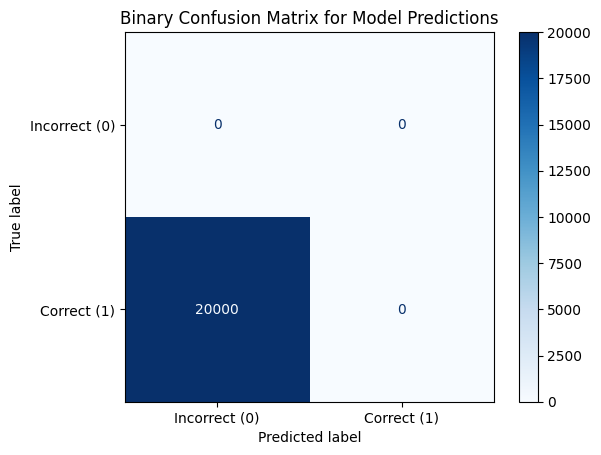

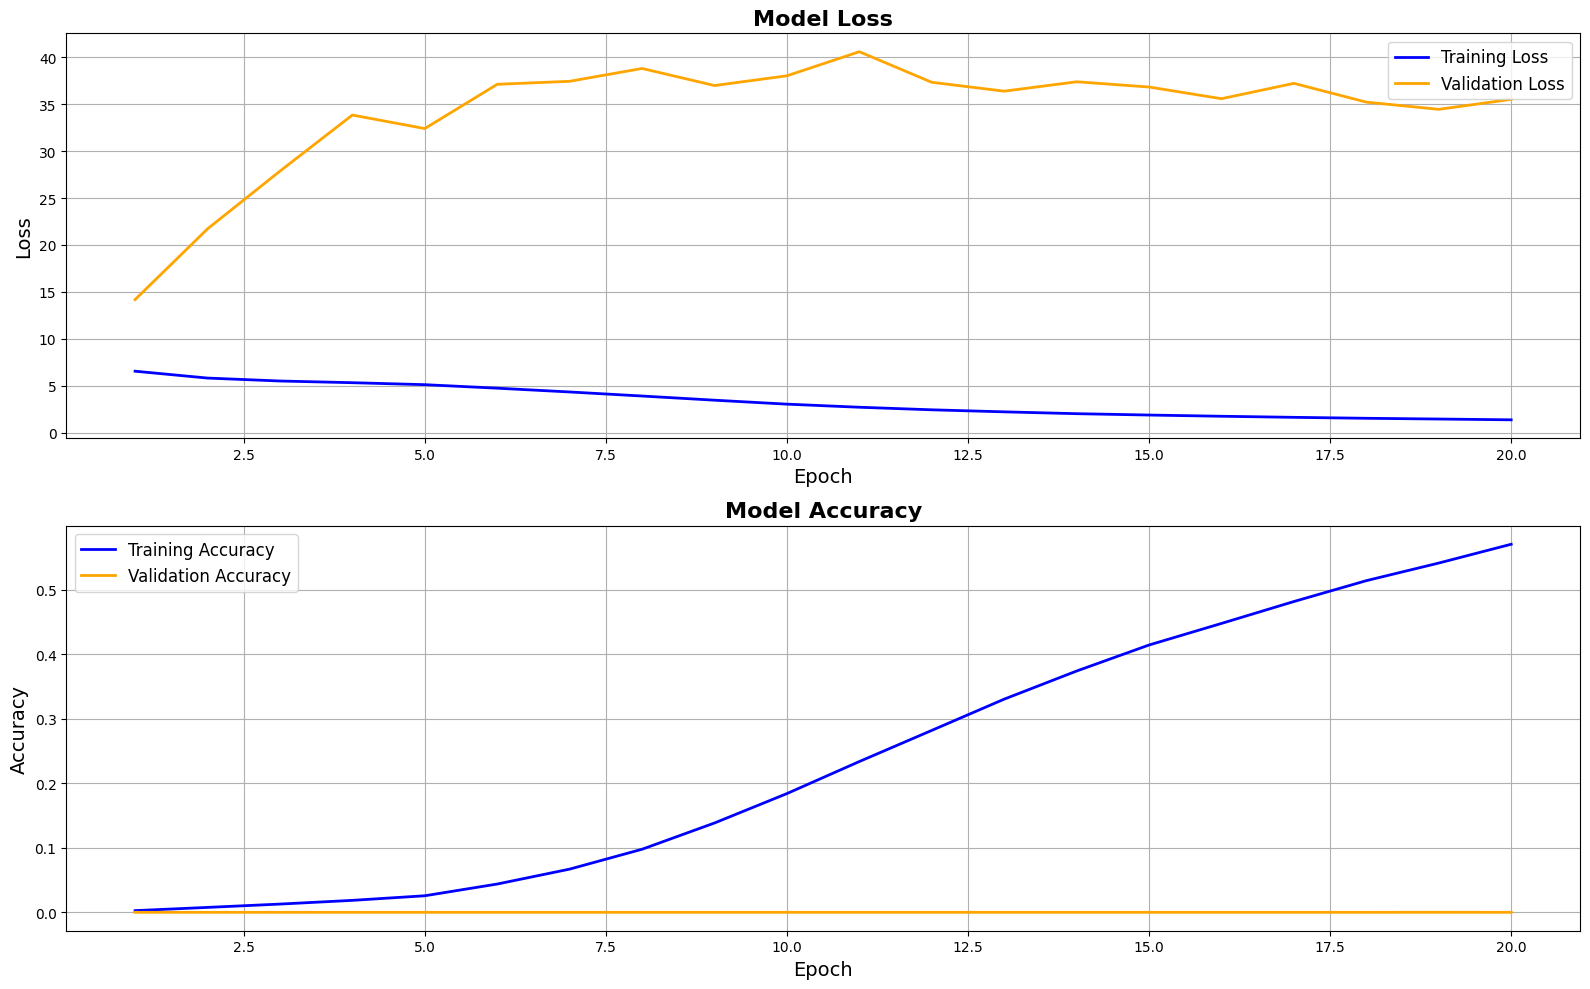

In [51]:
get_stat_history(_predictions, test_labels, _history)

basic unseen
unseen labels + lrs + earlystopping

Completed epochs: 11

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


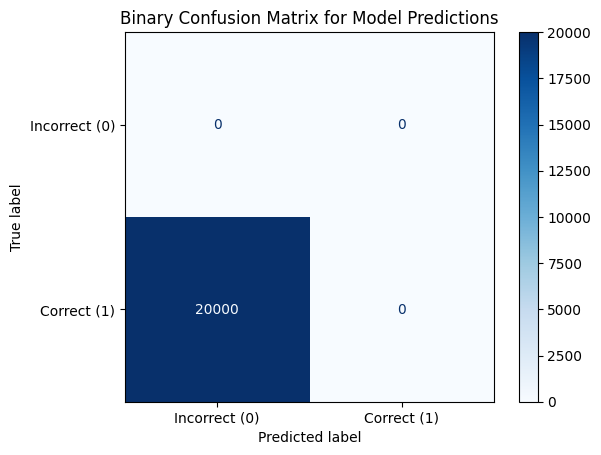

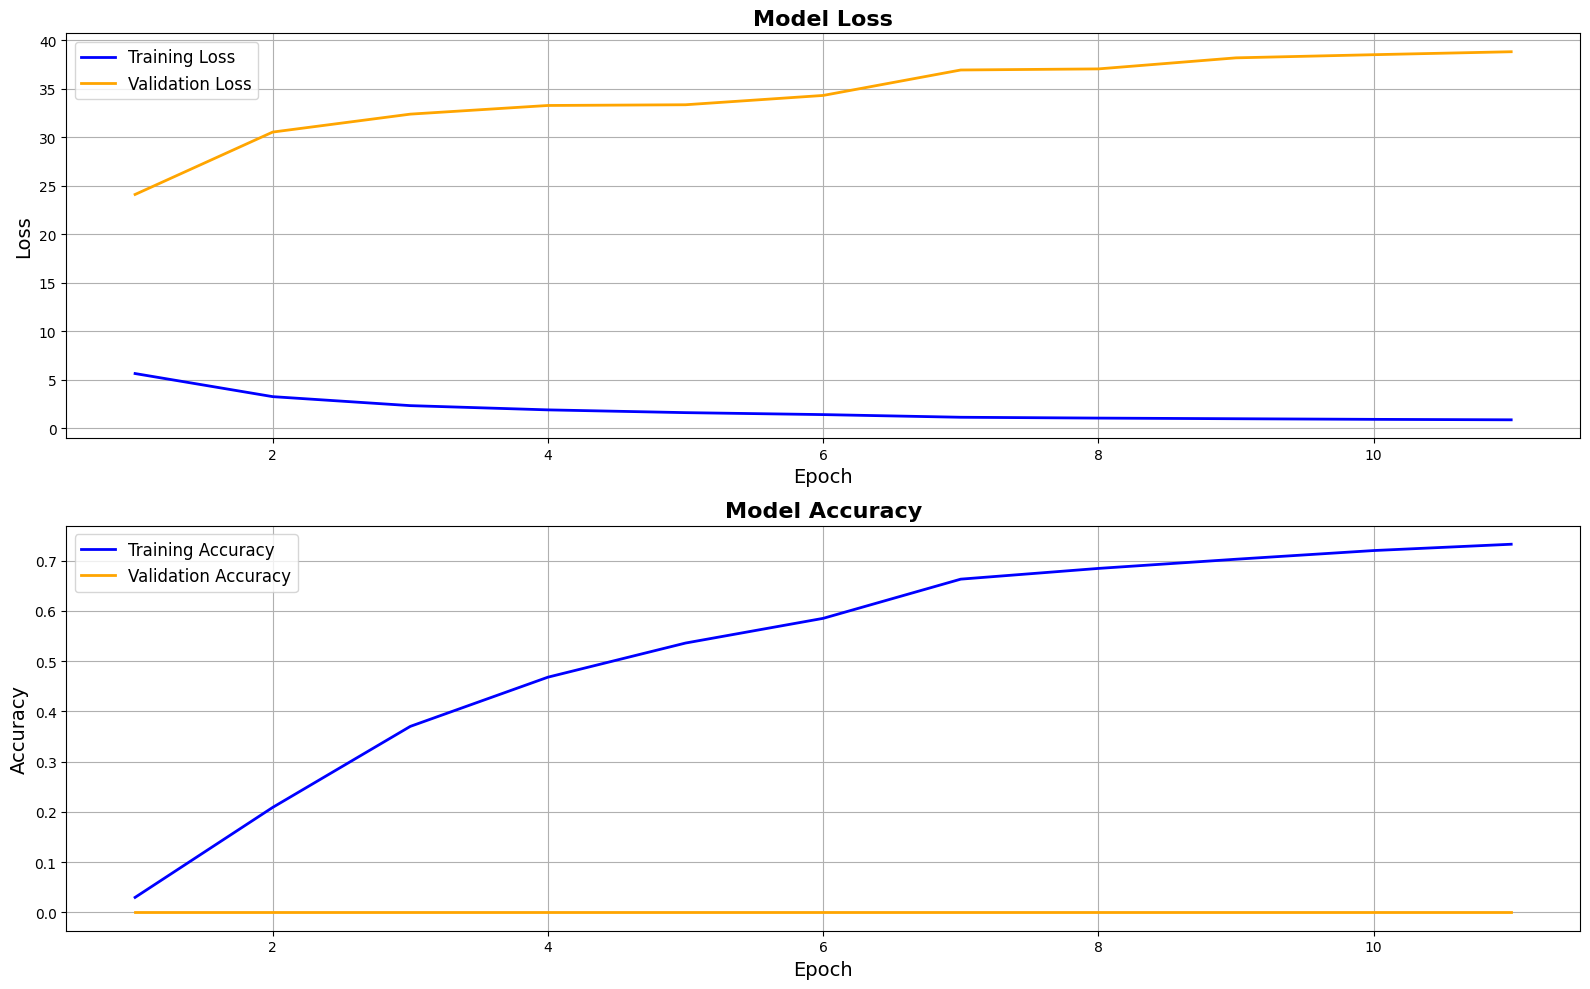

unseen labels + earlystopping

Completed epochs: 11

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


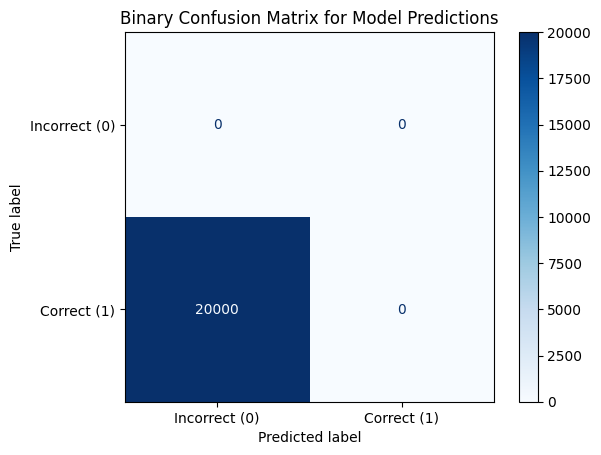

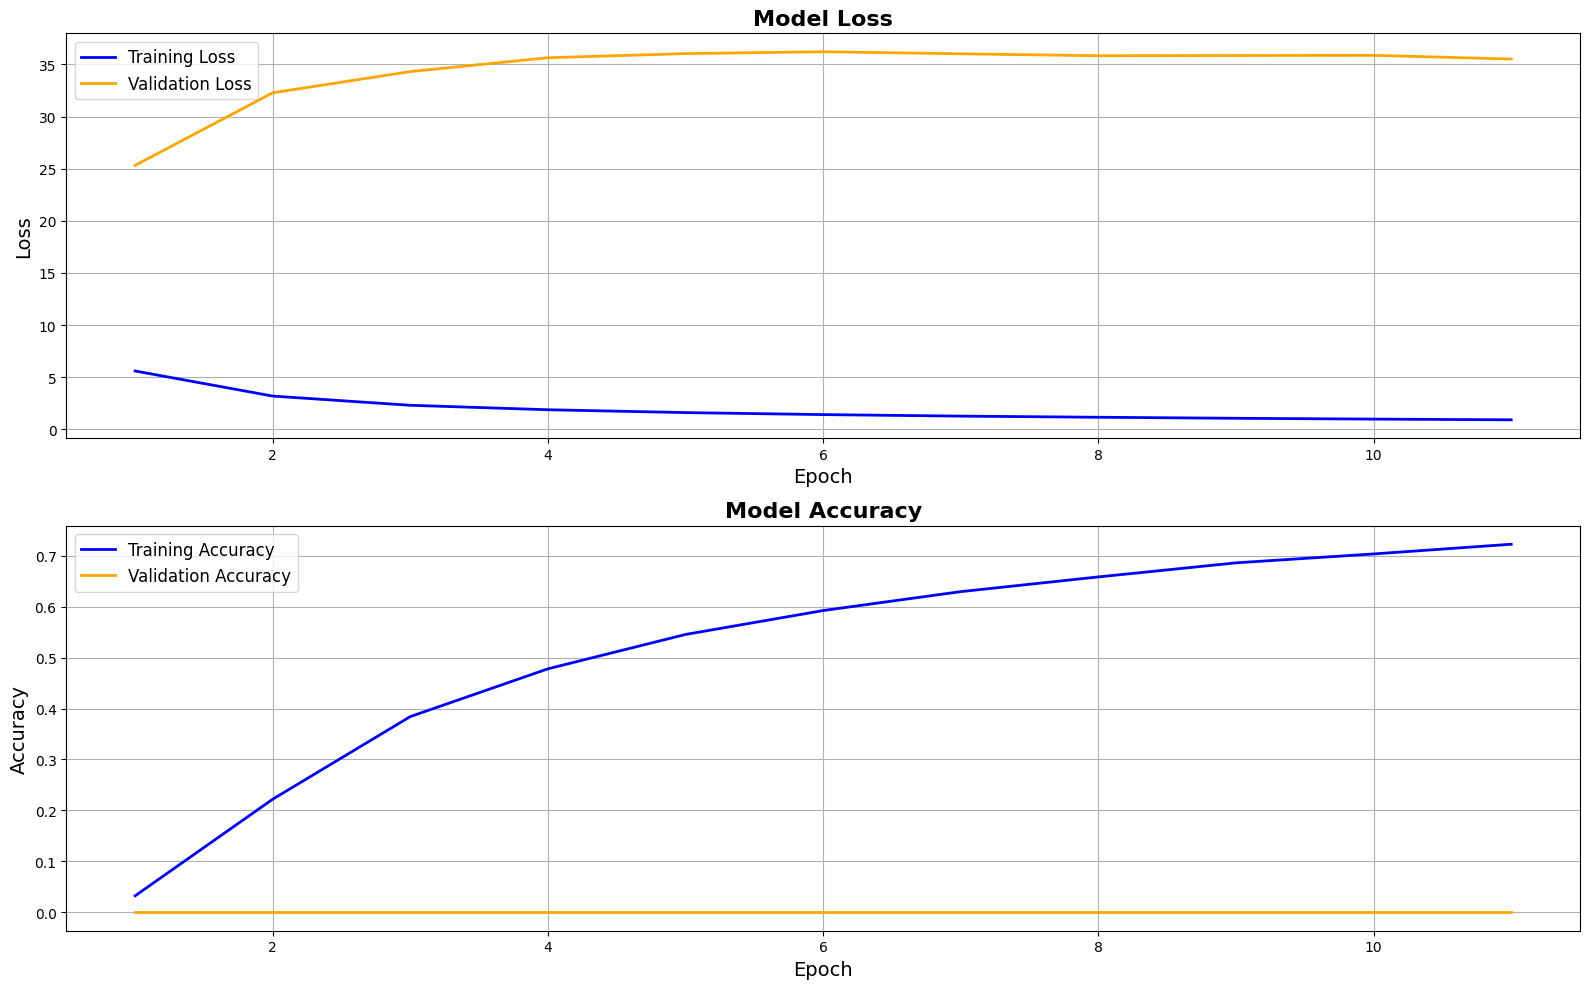

unseen labels + 50 epochs

Completed epochs: 50

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


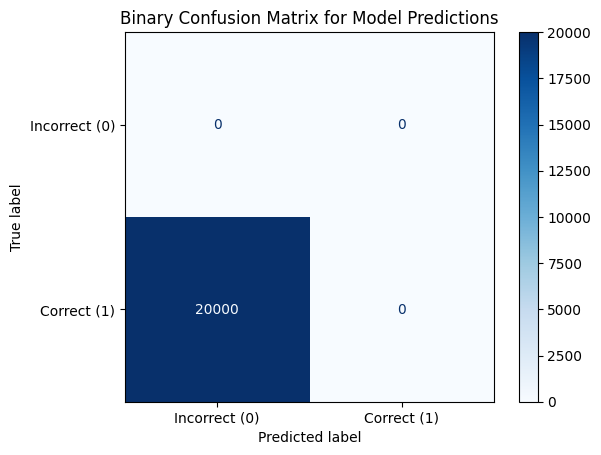

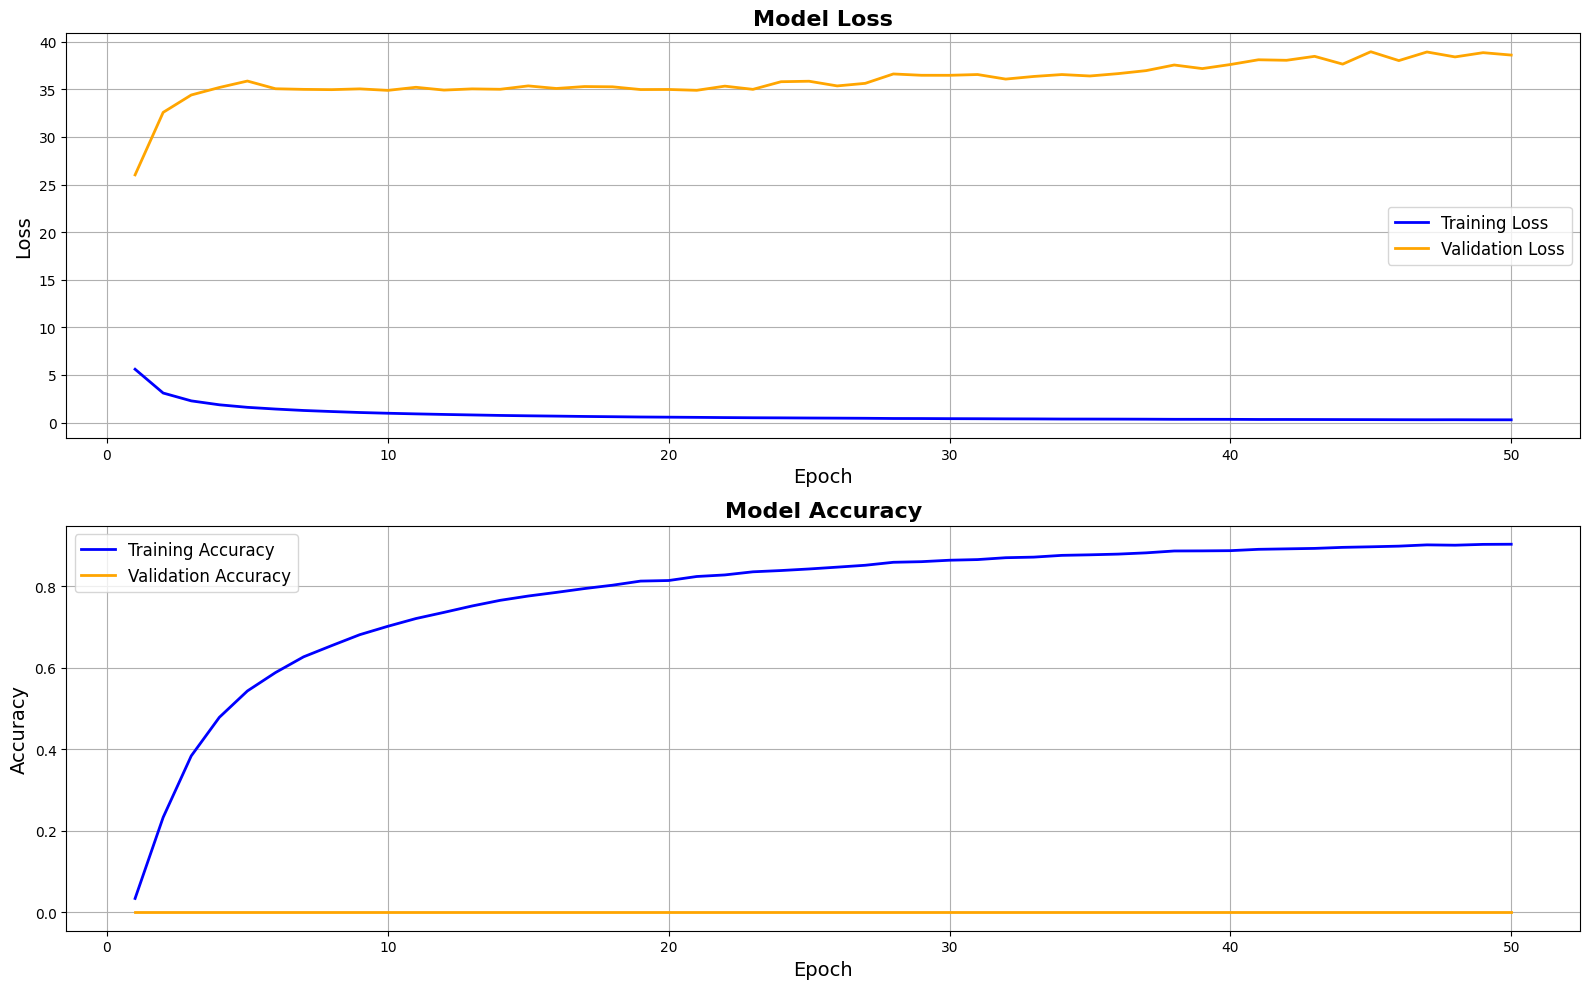

unseen labels + 25 epochs

Completed epochs: 25

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


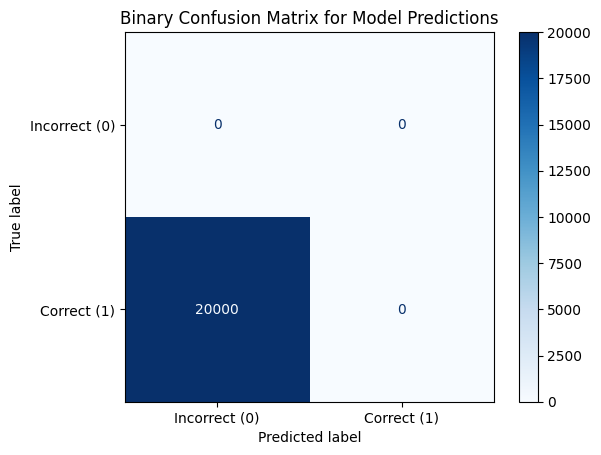

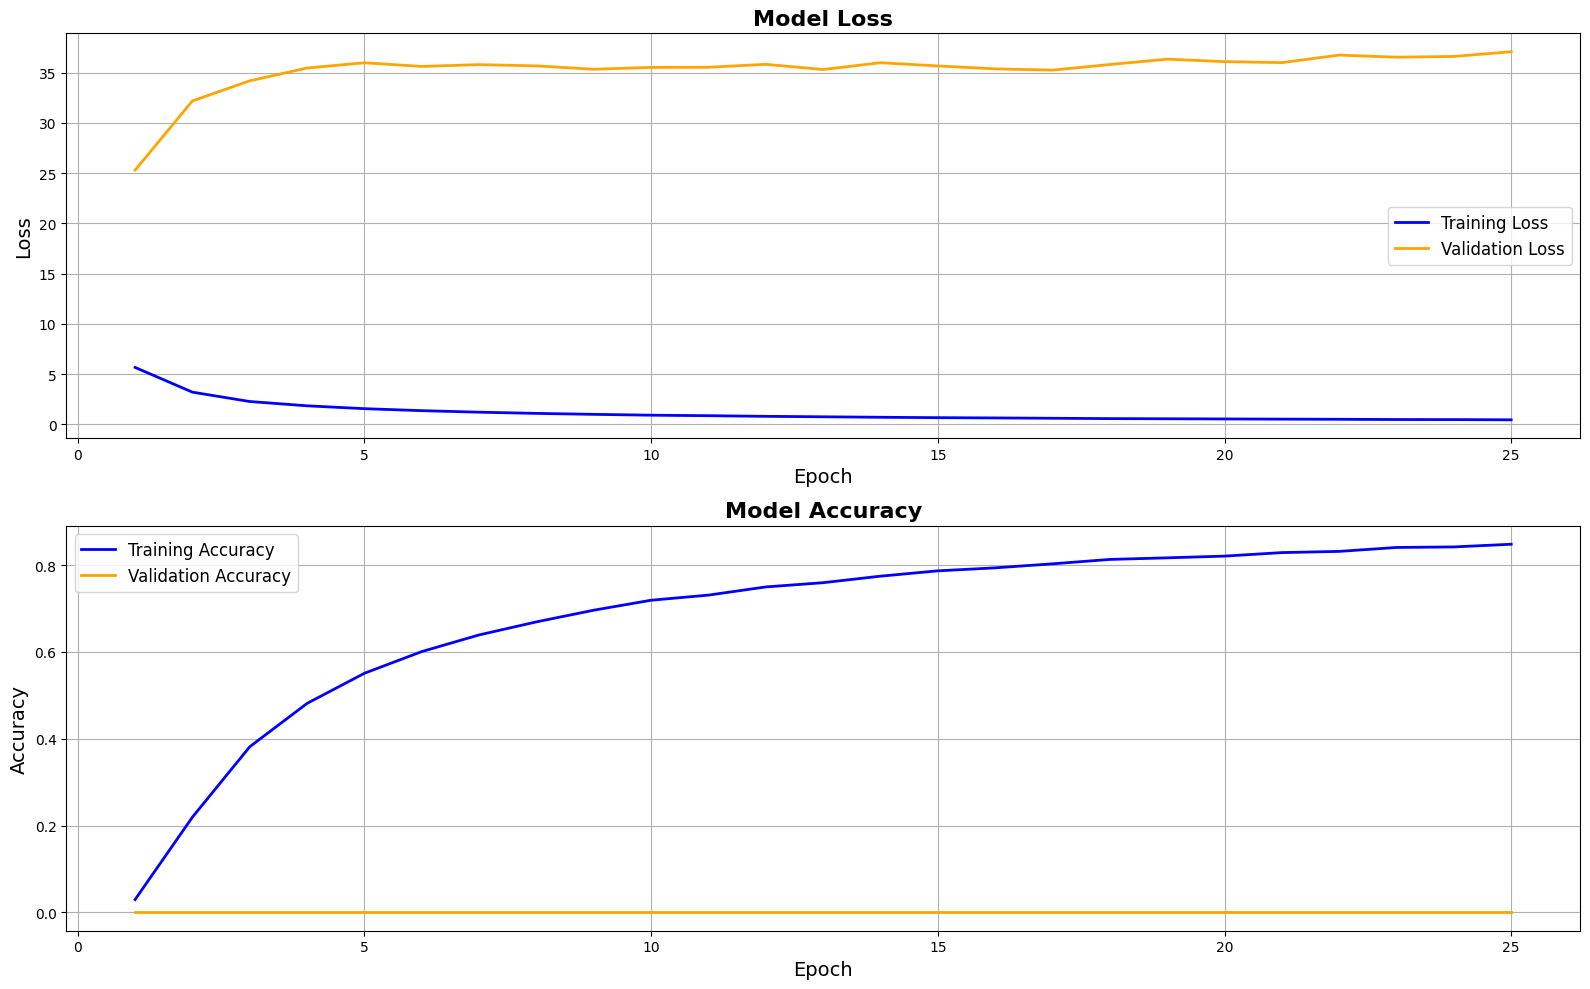

In [52]:
print("basic unseen")
print("unseen labels + lrs + earlystopping")
get_stat_history(predictions1 ,test_labels , history1)
print("unseen labels + earlystopping")
get_stat_history(predictions_1,test_labels,history_1)
print("unseen labels + 50 epochs")
get_stat_history( predictions__1,test_labels, history__1)
print("unseen labels + 25 epochs")
get_stat_history( predictions___1,test_labels, history___1)



compelex unseen
unseen labels + lrs + earlystopping

Completed epochs: 11

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


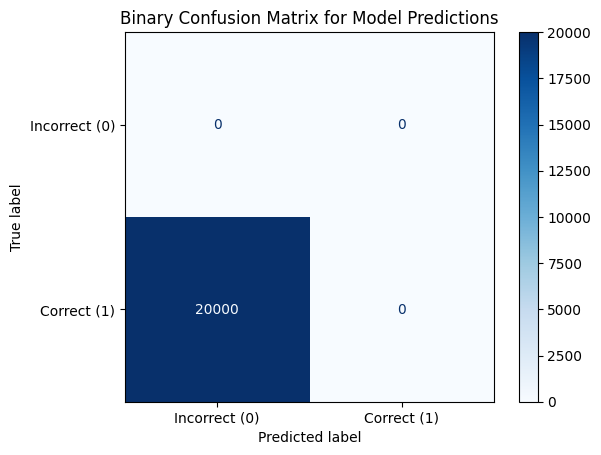

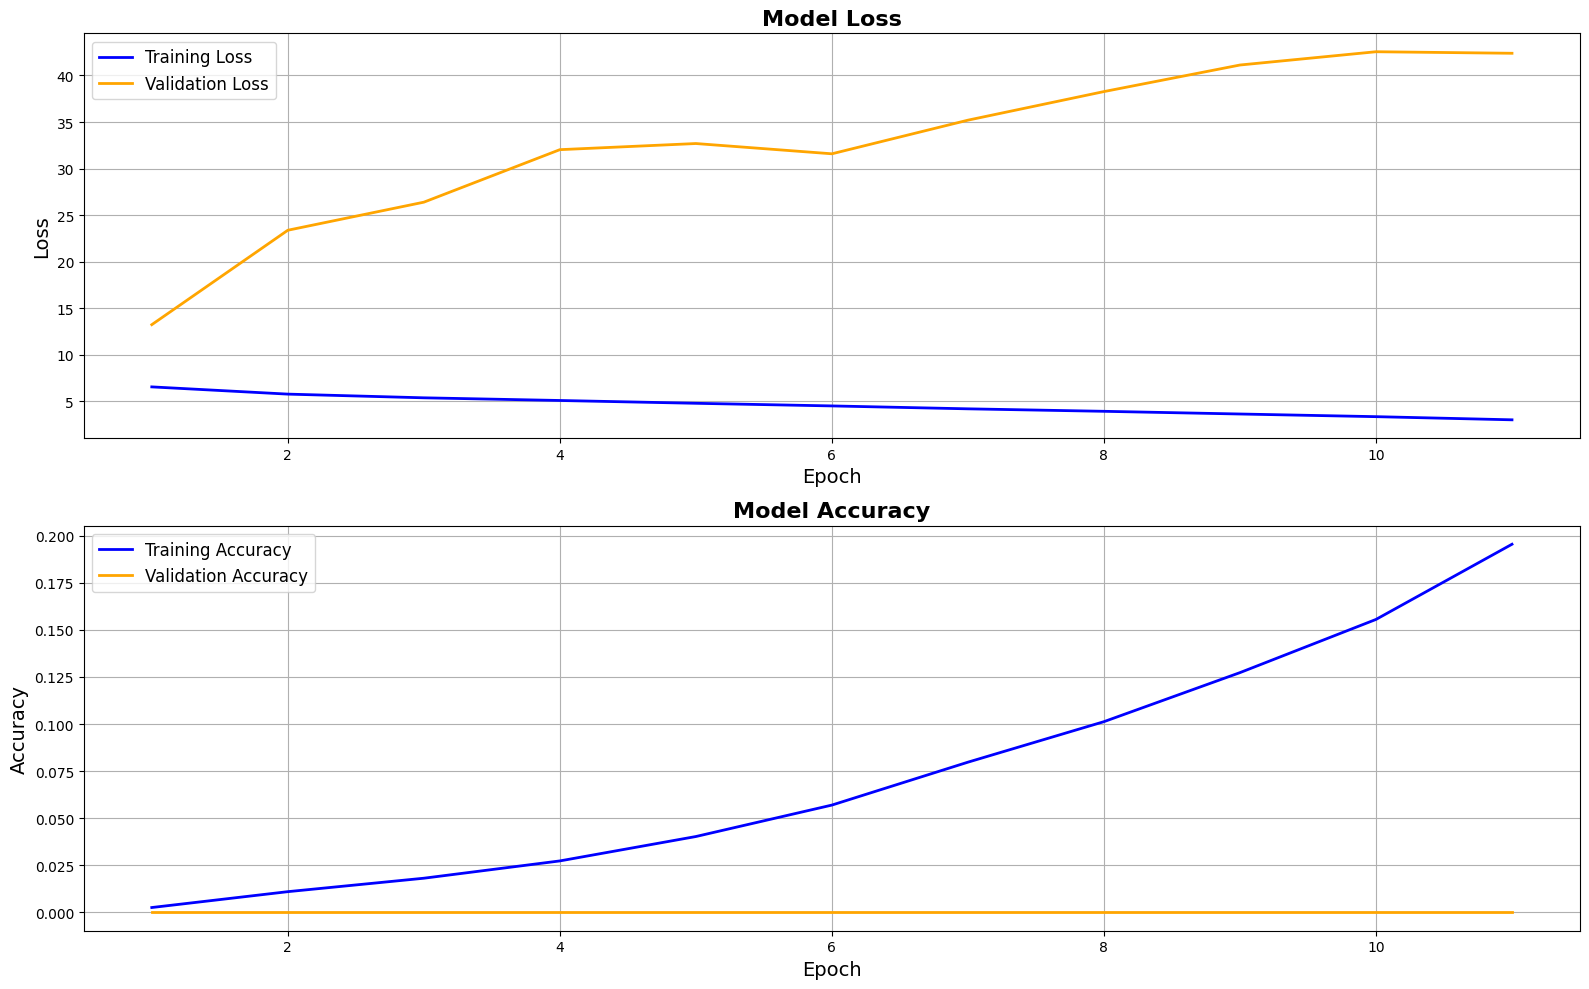

unseen labels + earlystopping

Completed epochs: 11

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


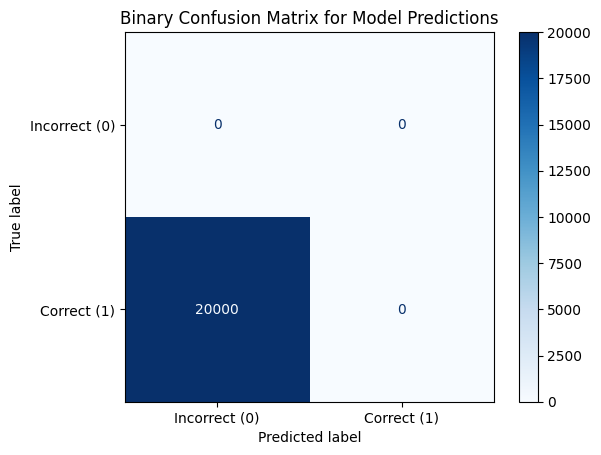

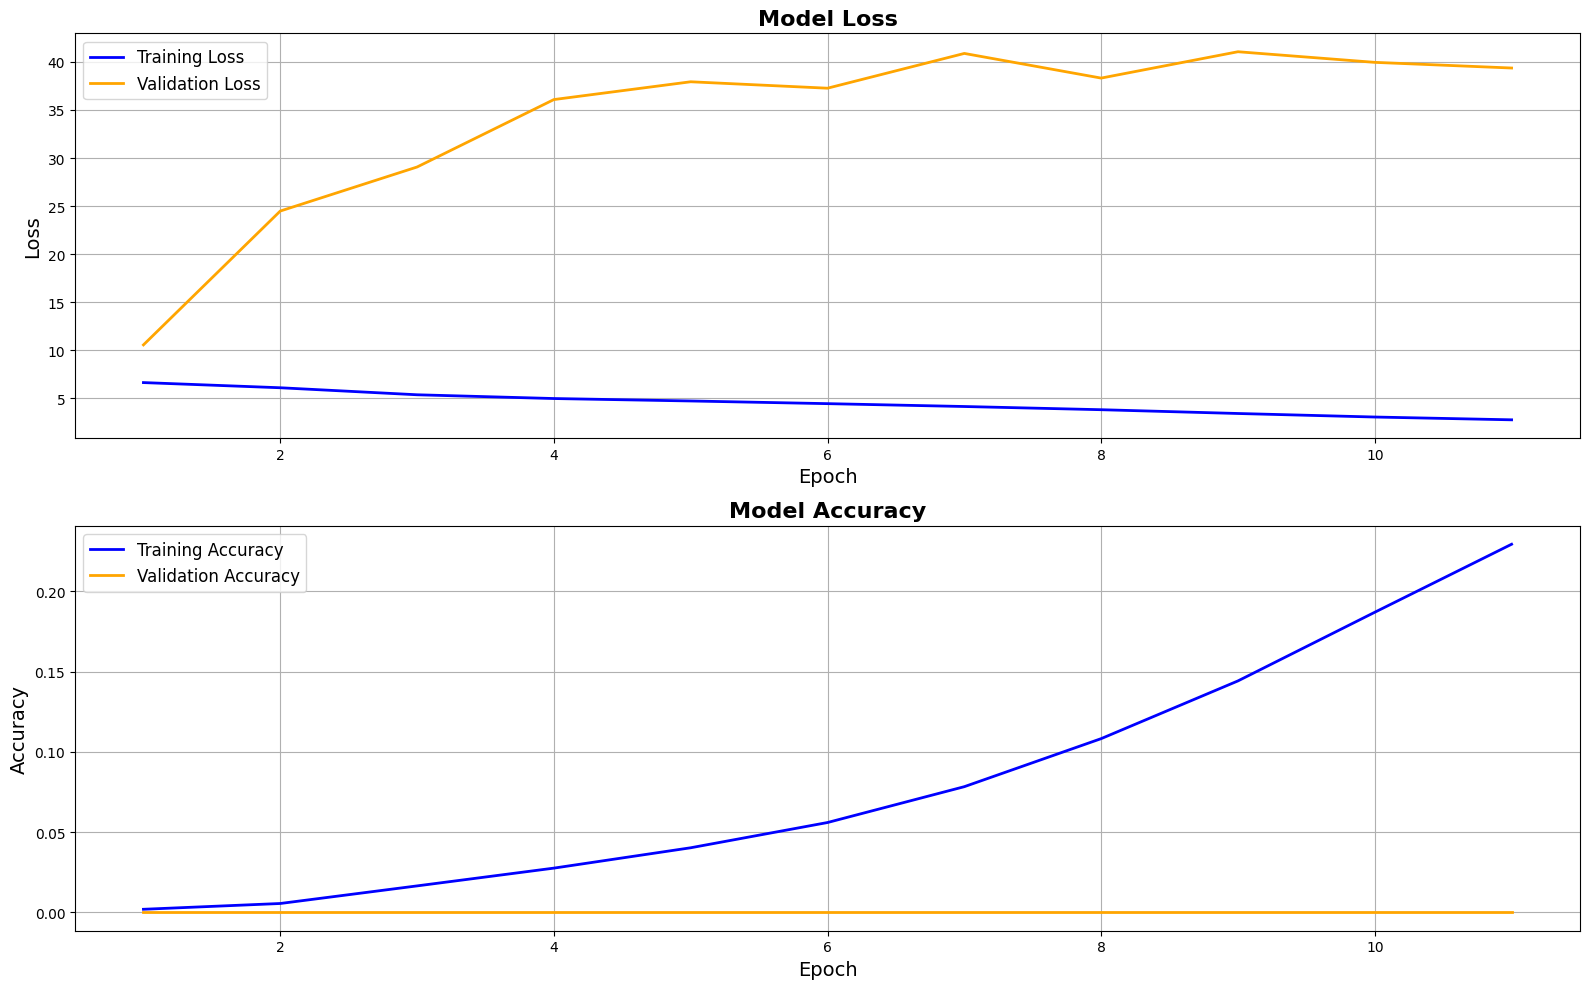

unseen labels + 50 epochs

Completed epochs: 50

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


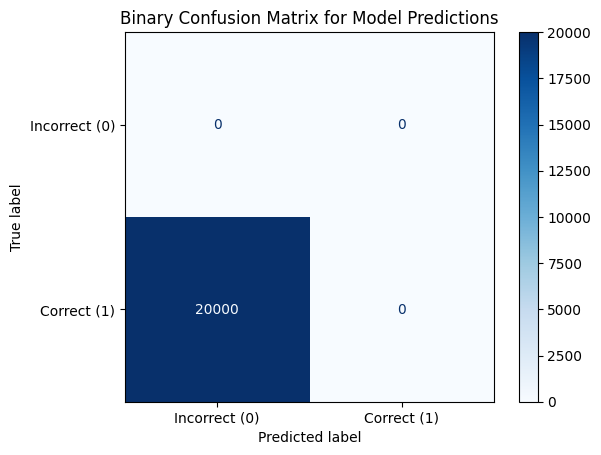

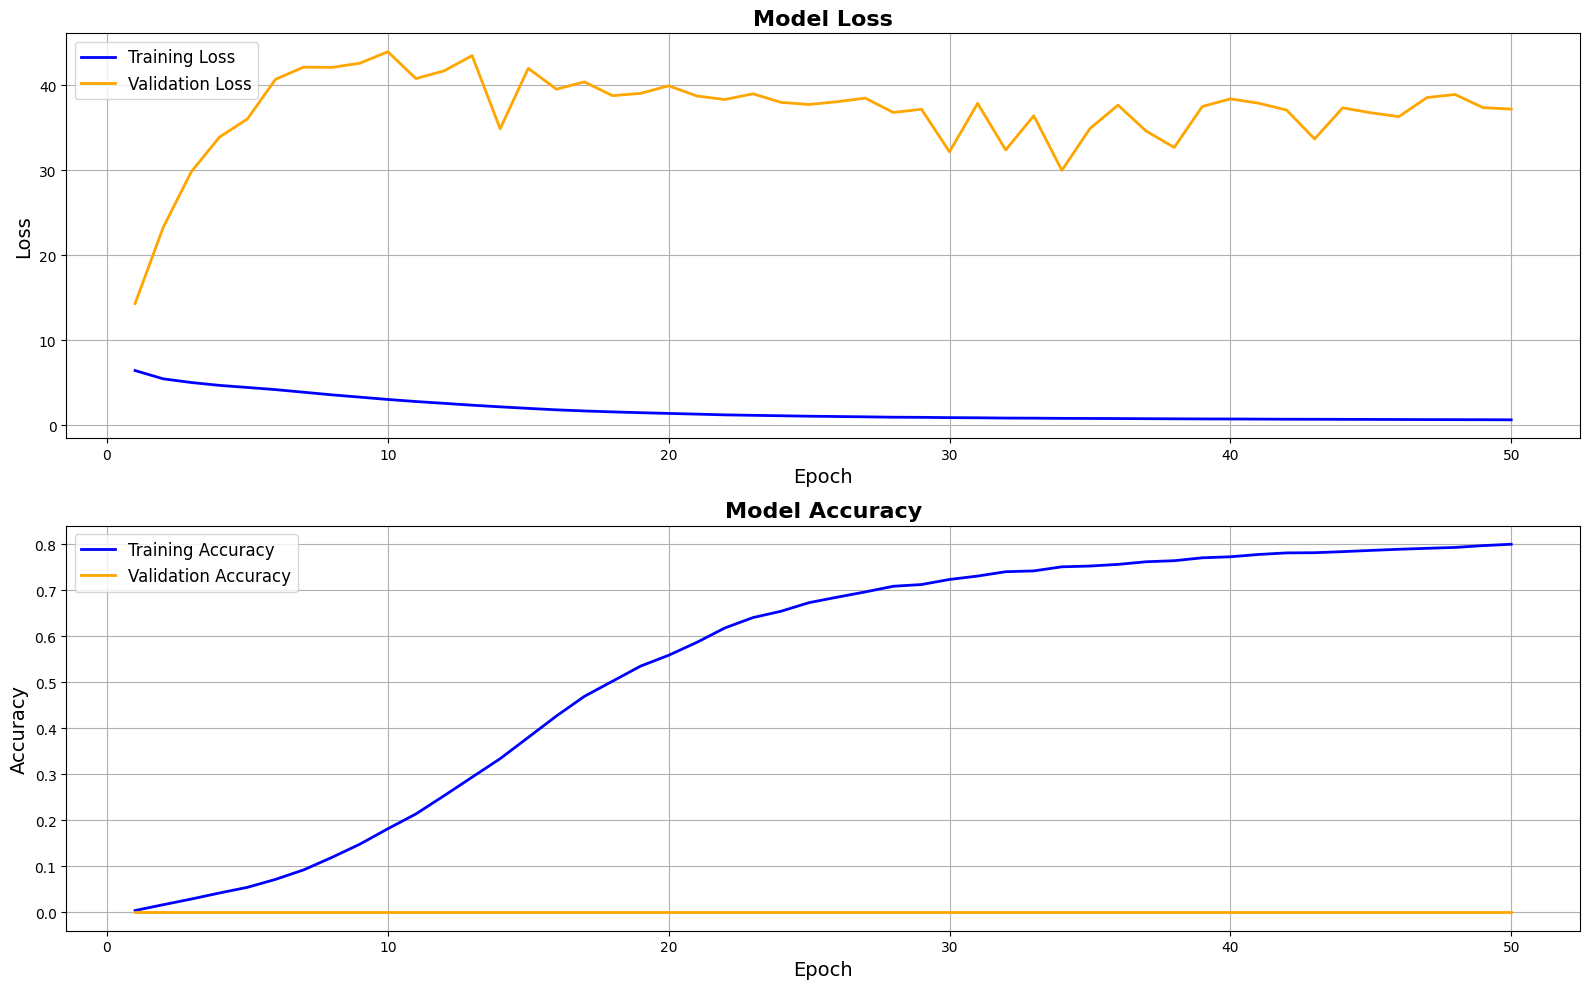

unseen labels + 25 epochs

Completed epochs: 25

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


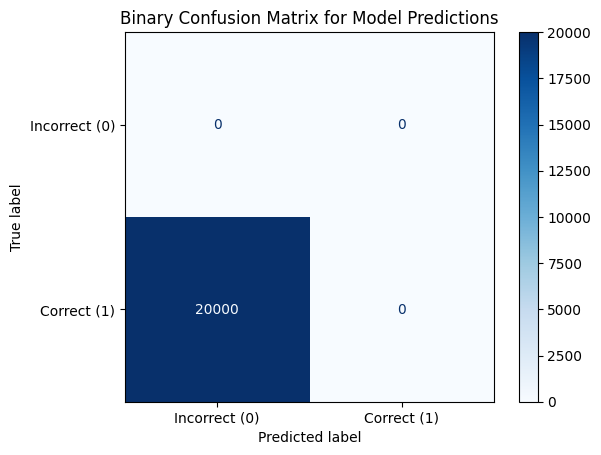

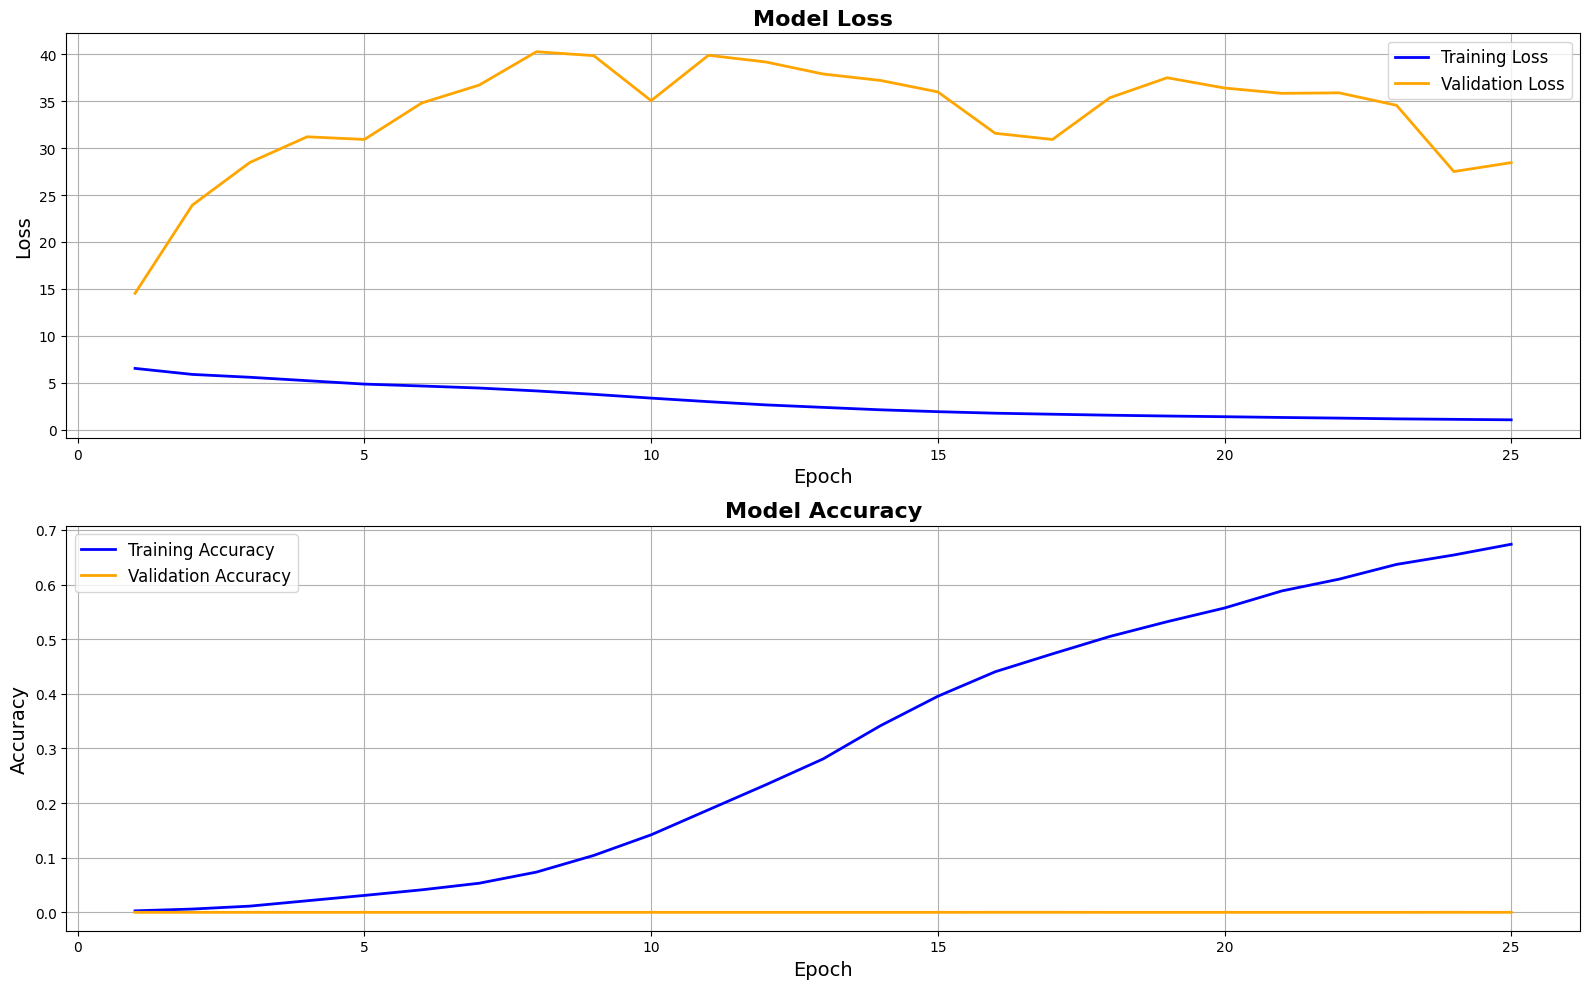

In [53]:
print("\n\ncompelex unseen")
print("unseen labels + lrs + earlystopping")
get_stat_history( predictions2,test_labels,history2 )
print("unseen labels + earlystopping")
get_stat_history(predictions_2,test_labels, history_2)
print("unseen labels + 50 epochs")
get_stat_history(predictions__2,test_labels,history__2 )
print("unseen labels + 25 epochs")
get_stat_history(predictions___2,test_labels, history___2)



basic seen
seen labels + lrs + earlystopping

Completed epochs: 25

Accuracy: 0.0009
F1 Score (Macro Average): 0.0000


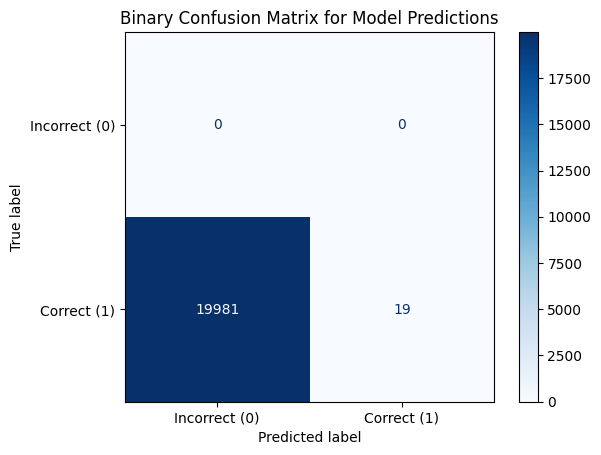

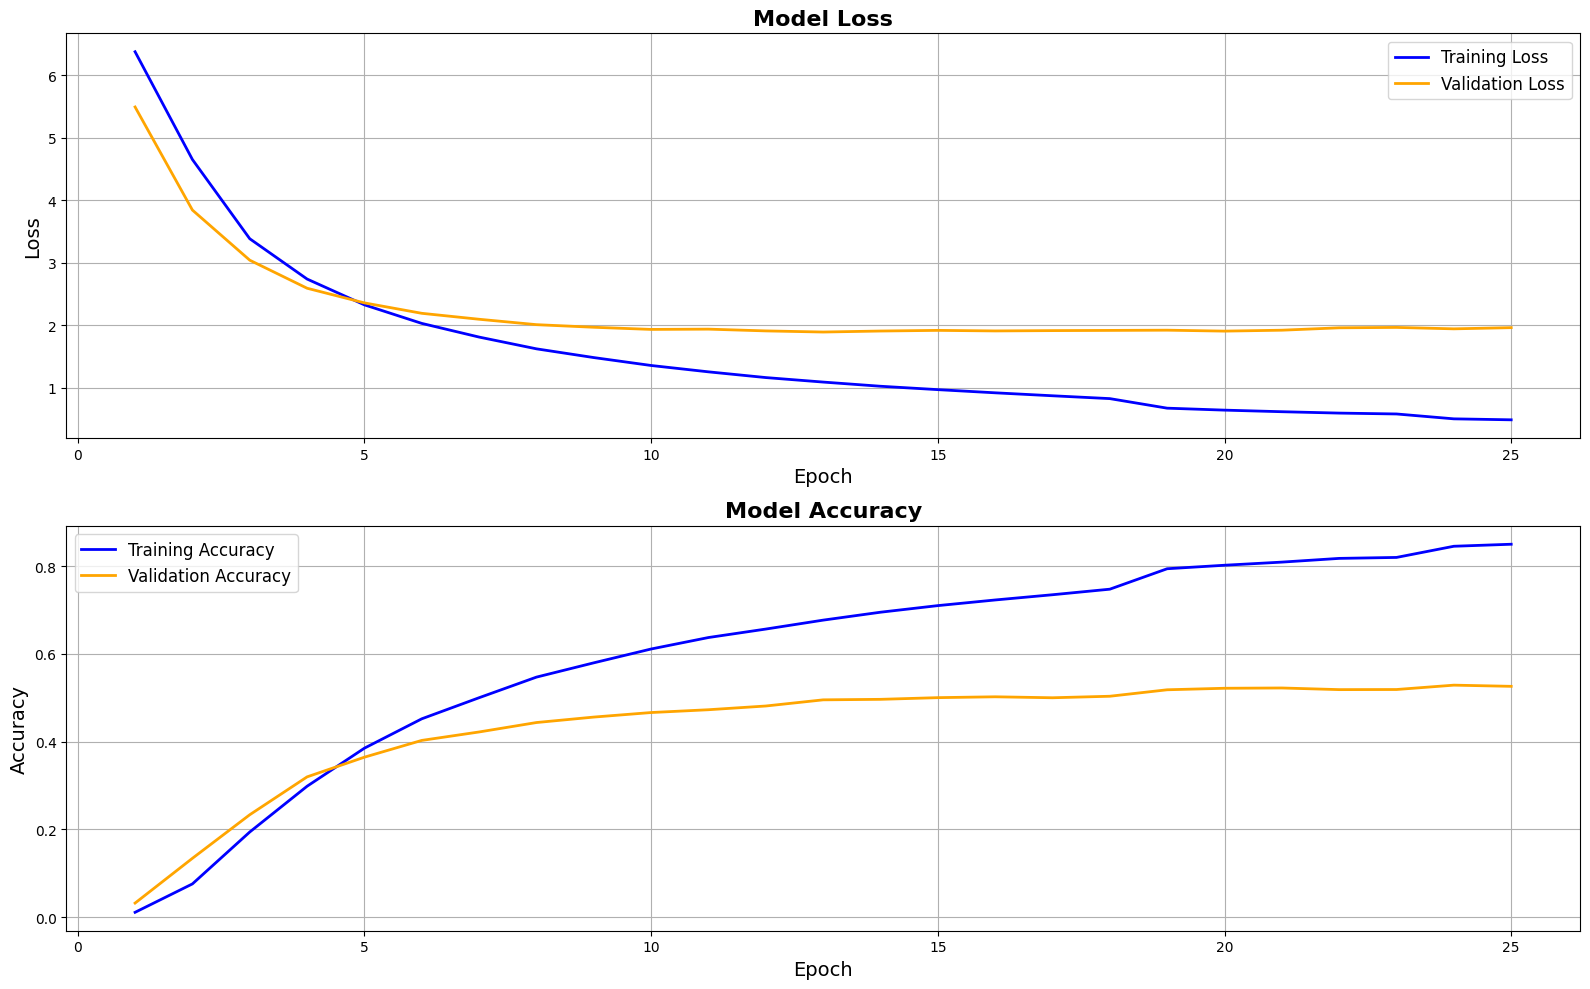

seen labels + earlystopping

Completed epochs: 50

Accuracy: 0.0012
F1 Score (Macro Average): 0.0000


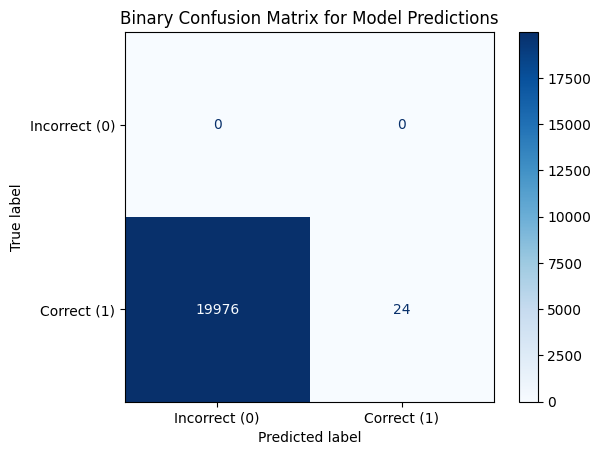

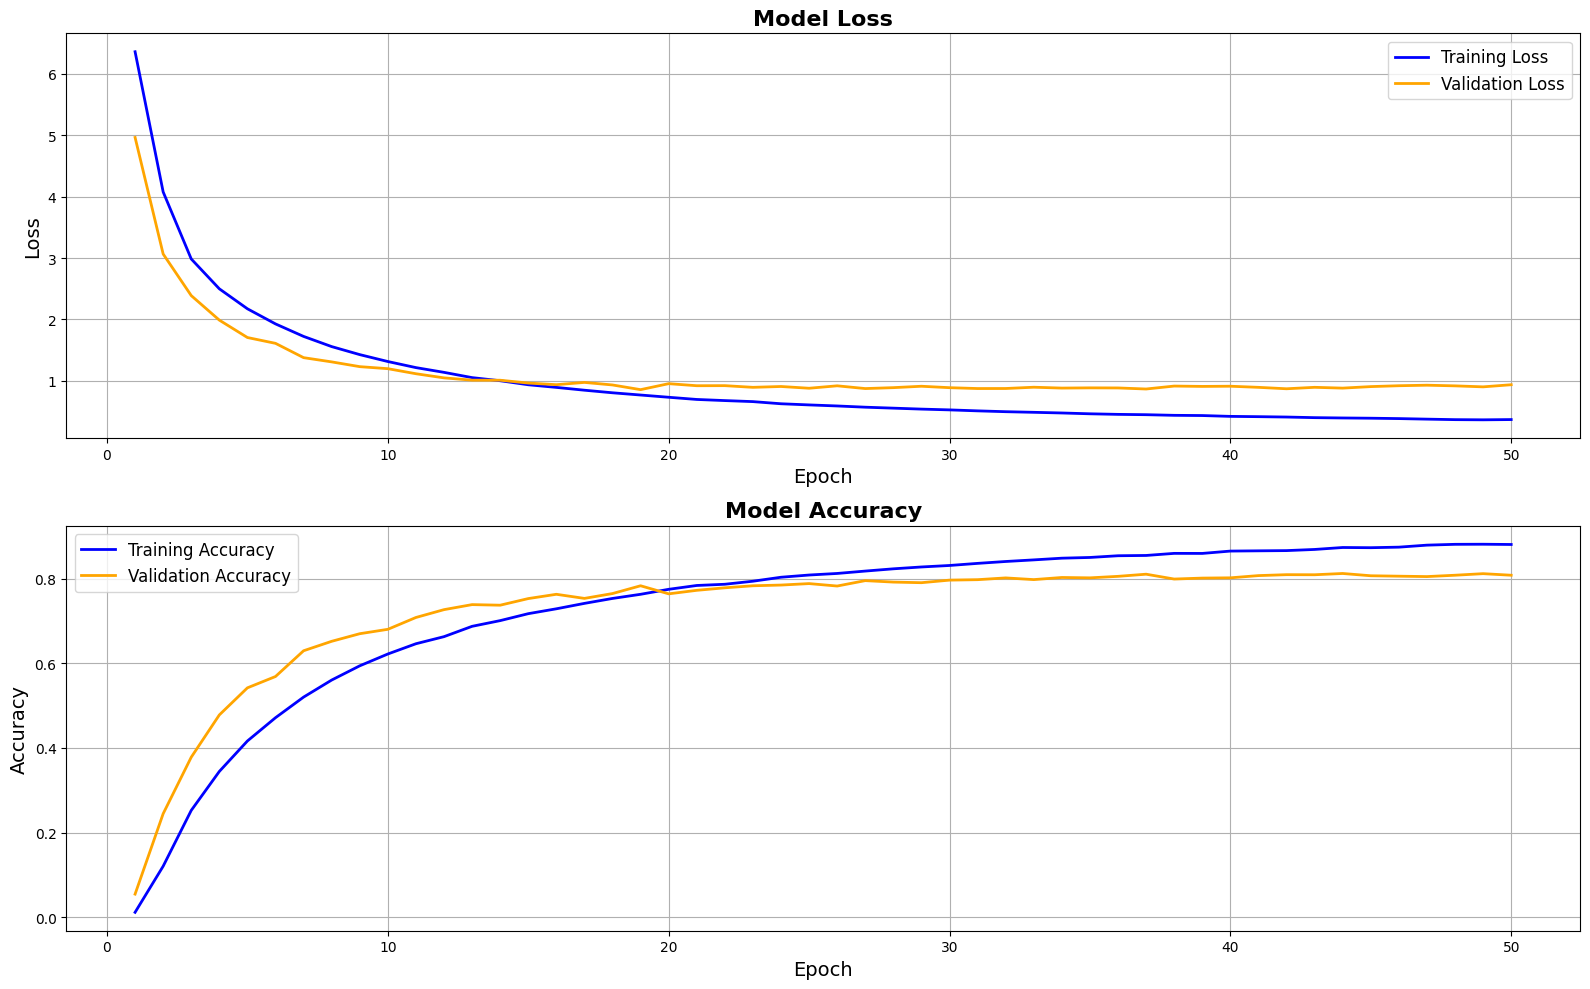

seen labels + 50 epochs

Completed epochs: 50

Accuracy: 0.0013
F1 Score (Macro Average): 0.0000


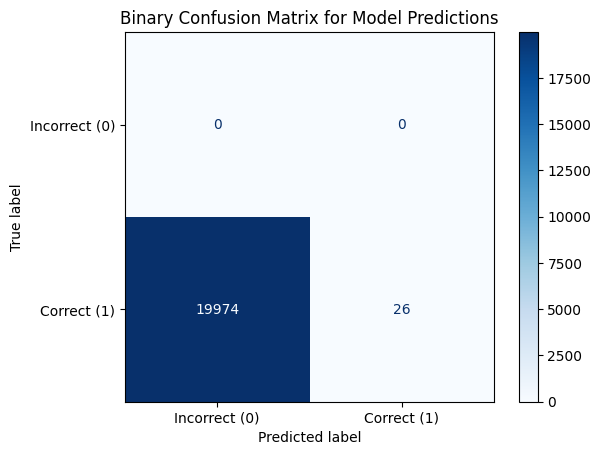

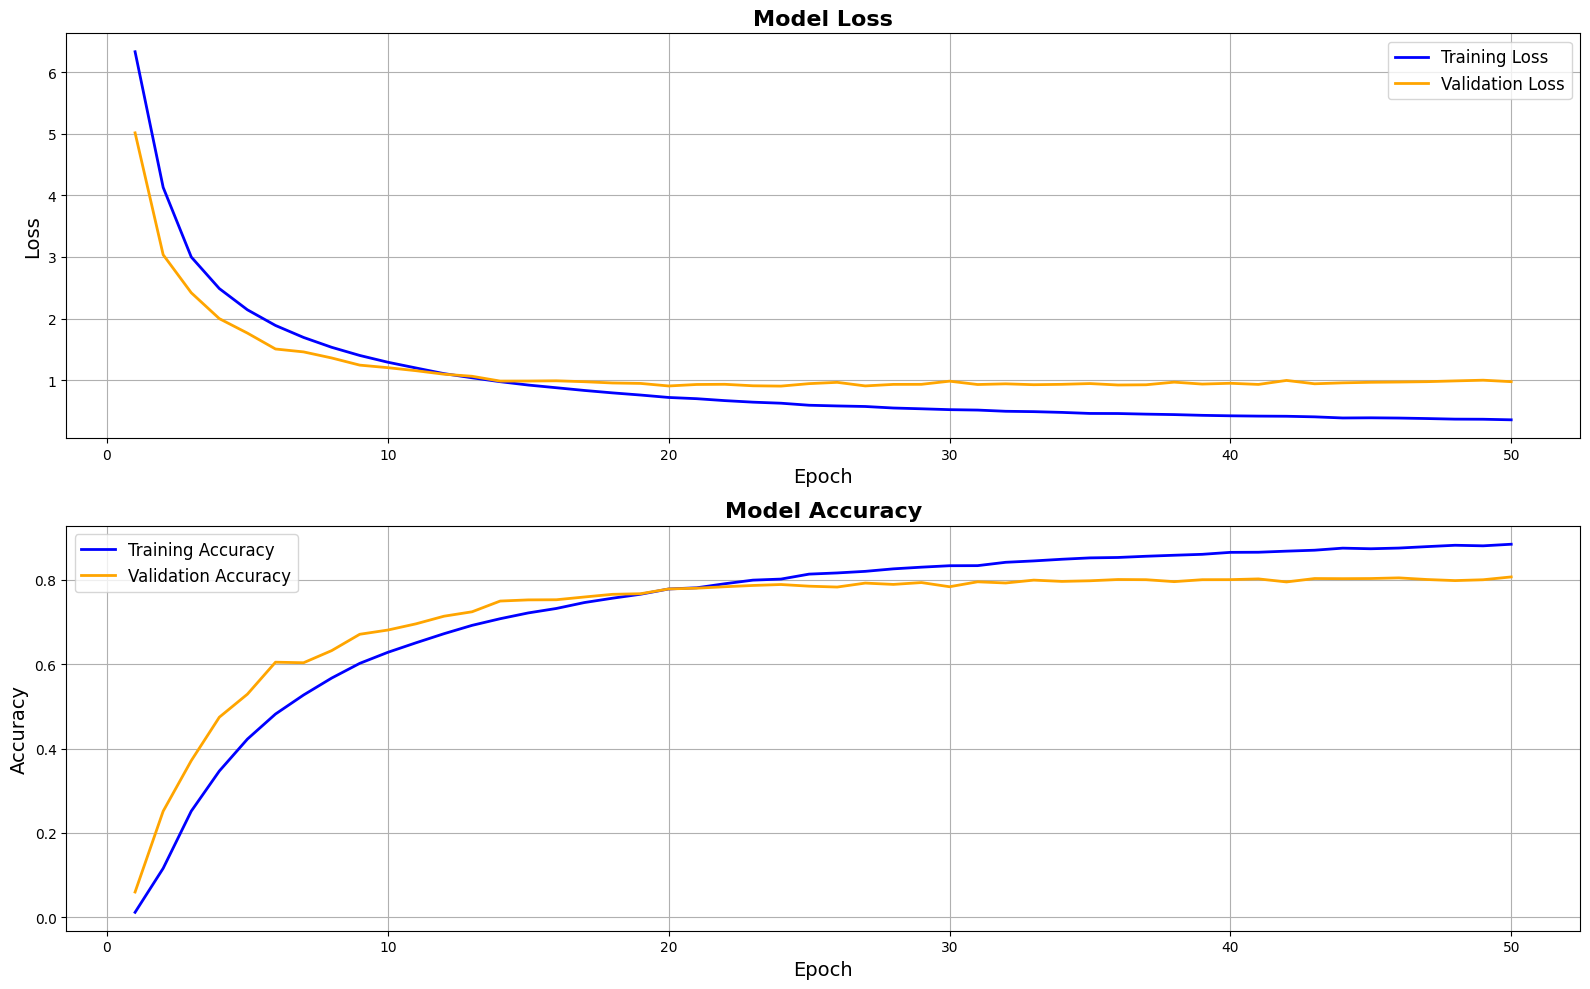

seen labels + 25 epochs

Completed epochs: 25

Accuracy: 0.0008
F1 Score (Macro Average): 0.0000


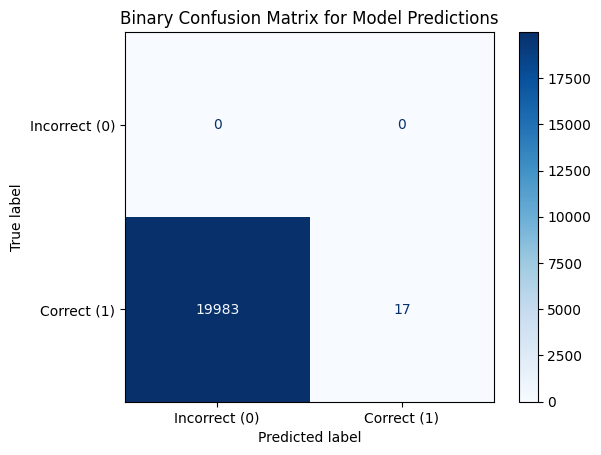

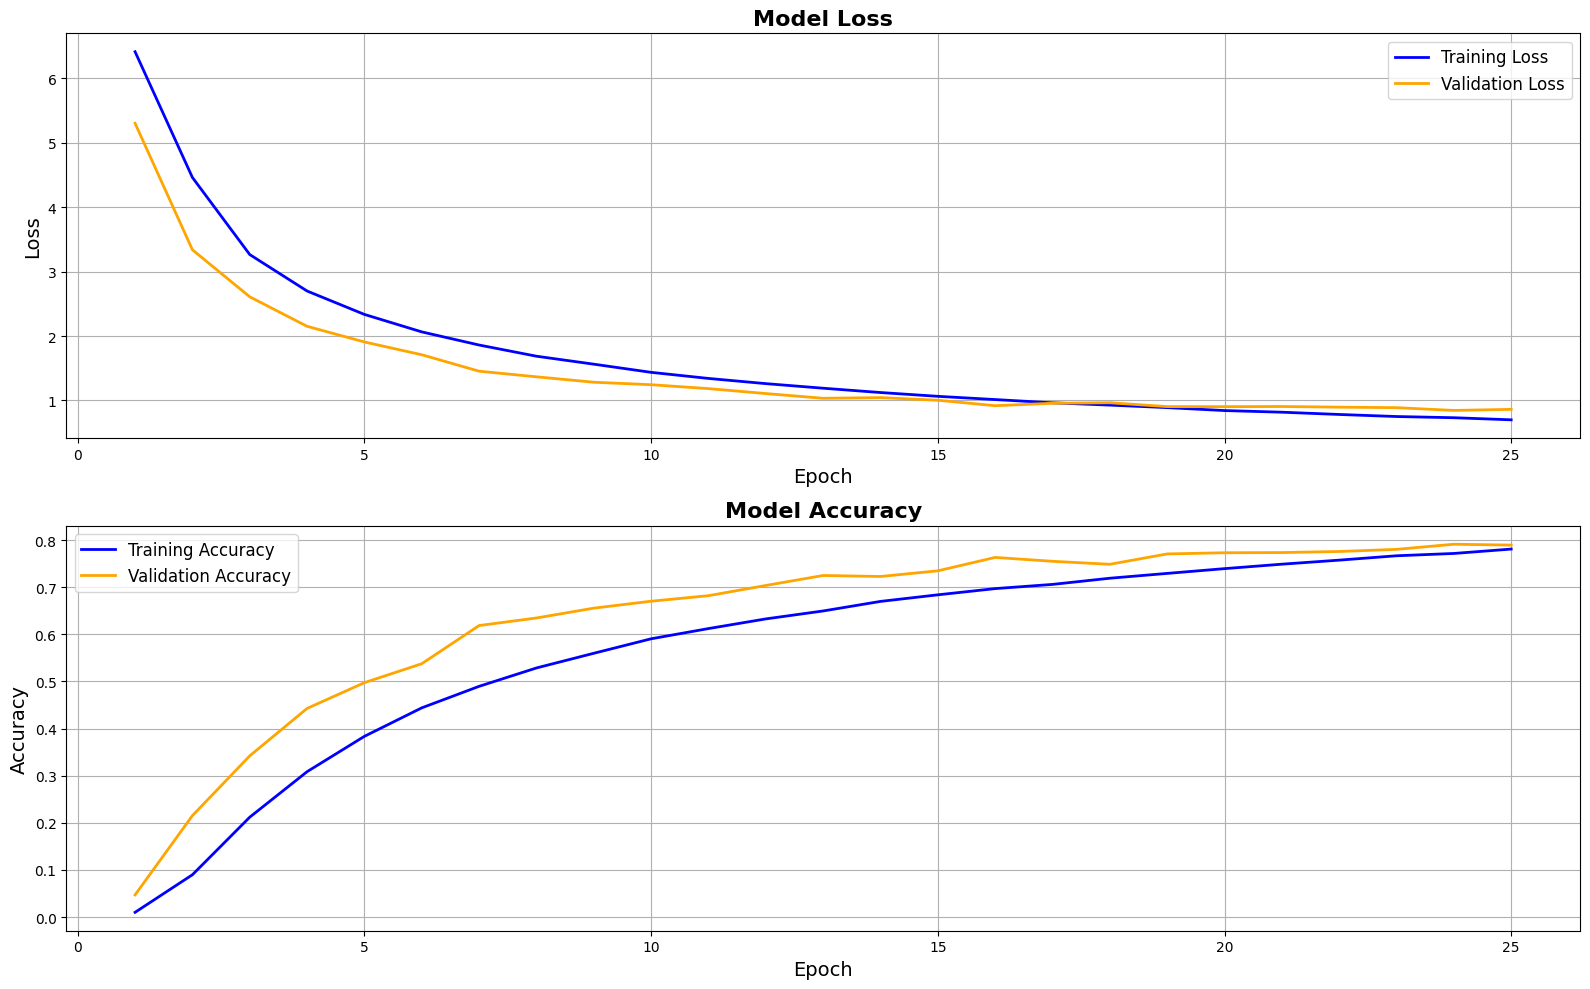

In [54]:
print("\n\nbasic seen")
print("seen labels + lrs + earlystopping")
get_stat_history( sp_predictions1,sp_test_labels, sp_history)
print("seen labels + earlystopping")
get_stat_history(sp_predictions_1,sp_test_labels, sp_history_1)
print("seen labels + 50 epochs")
get_stat_history( sp_predictions__1,sp_test_labels, sp_history__1)
print("seen labels + 25 epochs")
get_stat_history(sp_predictions___1,sp_test_labels , sp_history___1)



complex seen
seen labels + lrs + earlystopping

Completed epochs: 12

Accuracy: 0.0001
F1 Score (Macro Average): 0.0000


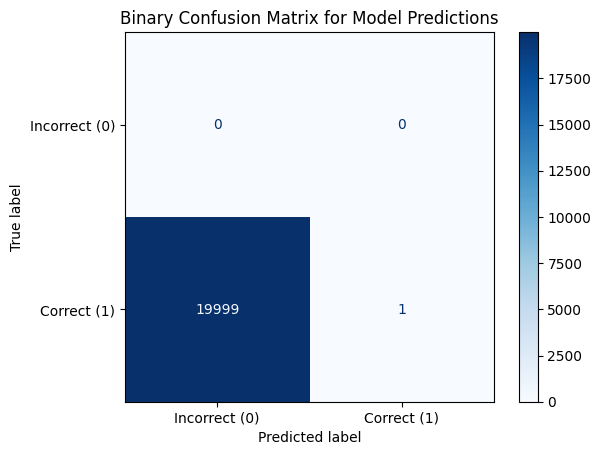

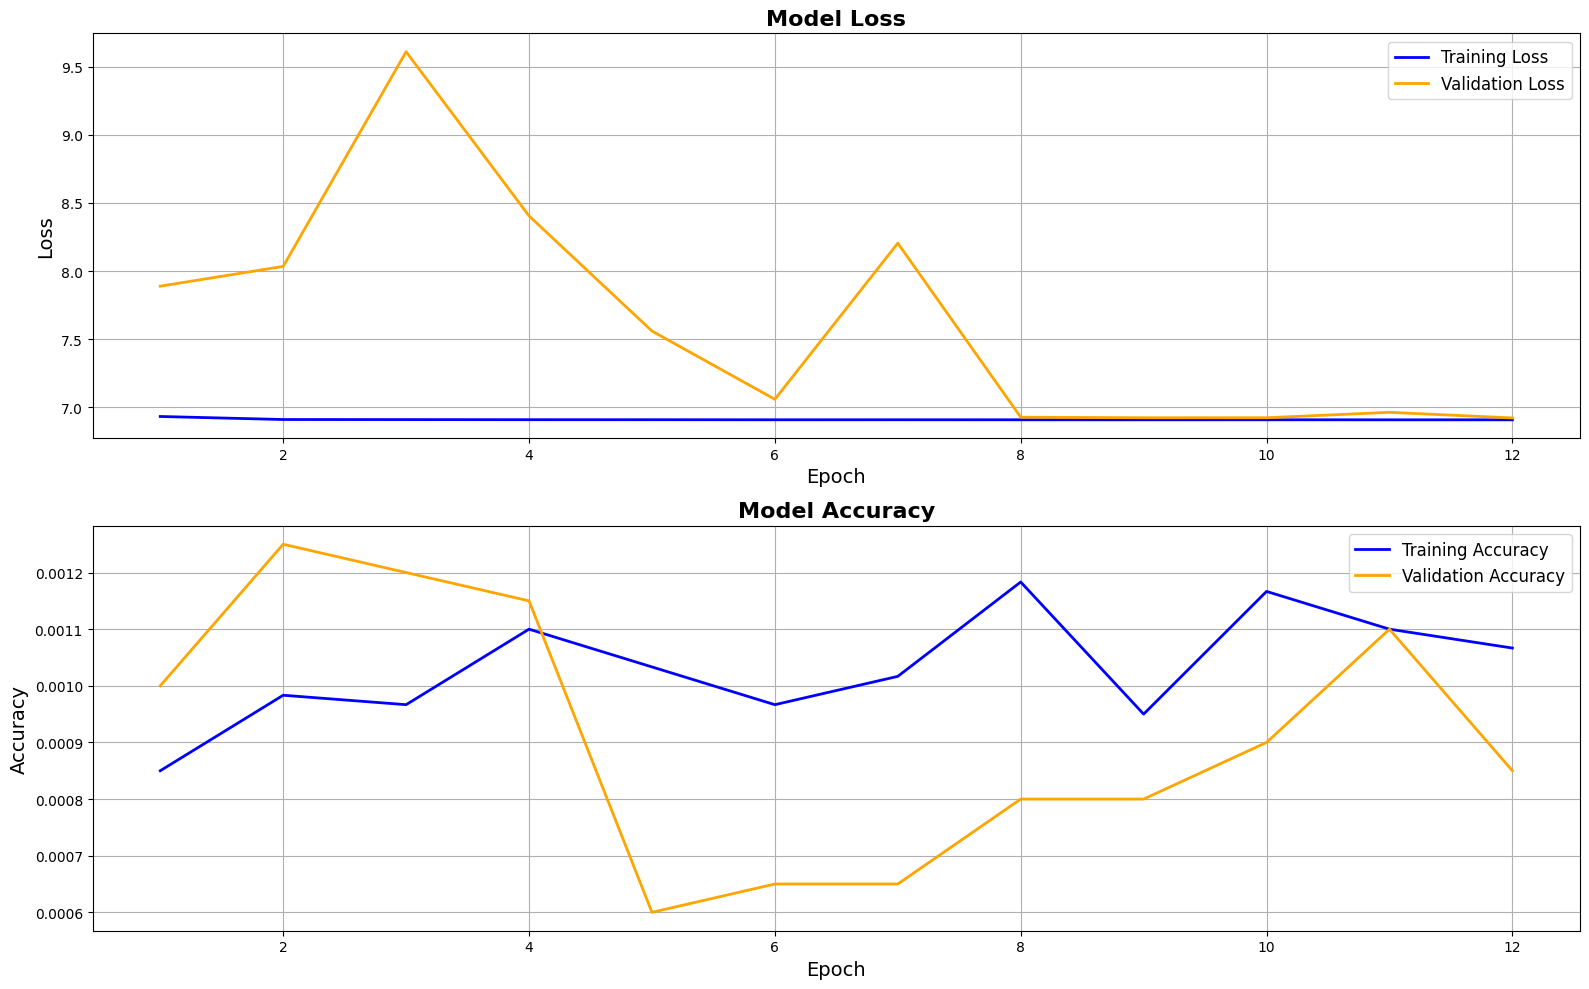

seen labels + earlystopping

Completed epochs: 13

Accuracy: 0.0001
F1 Score (Macro Average): 0.0000


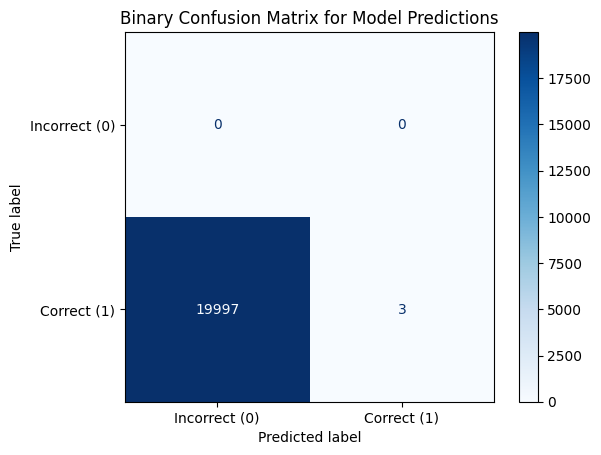

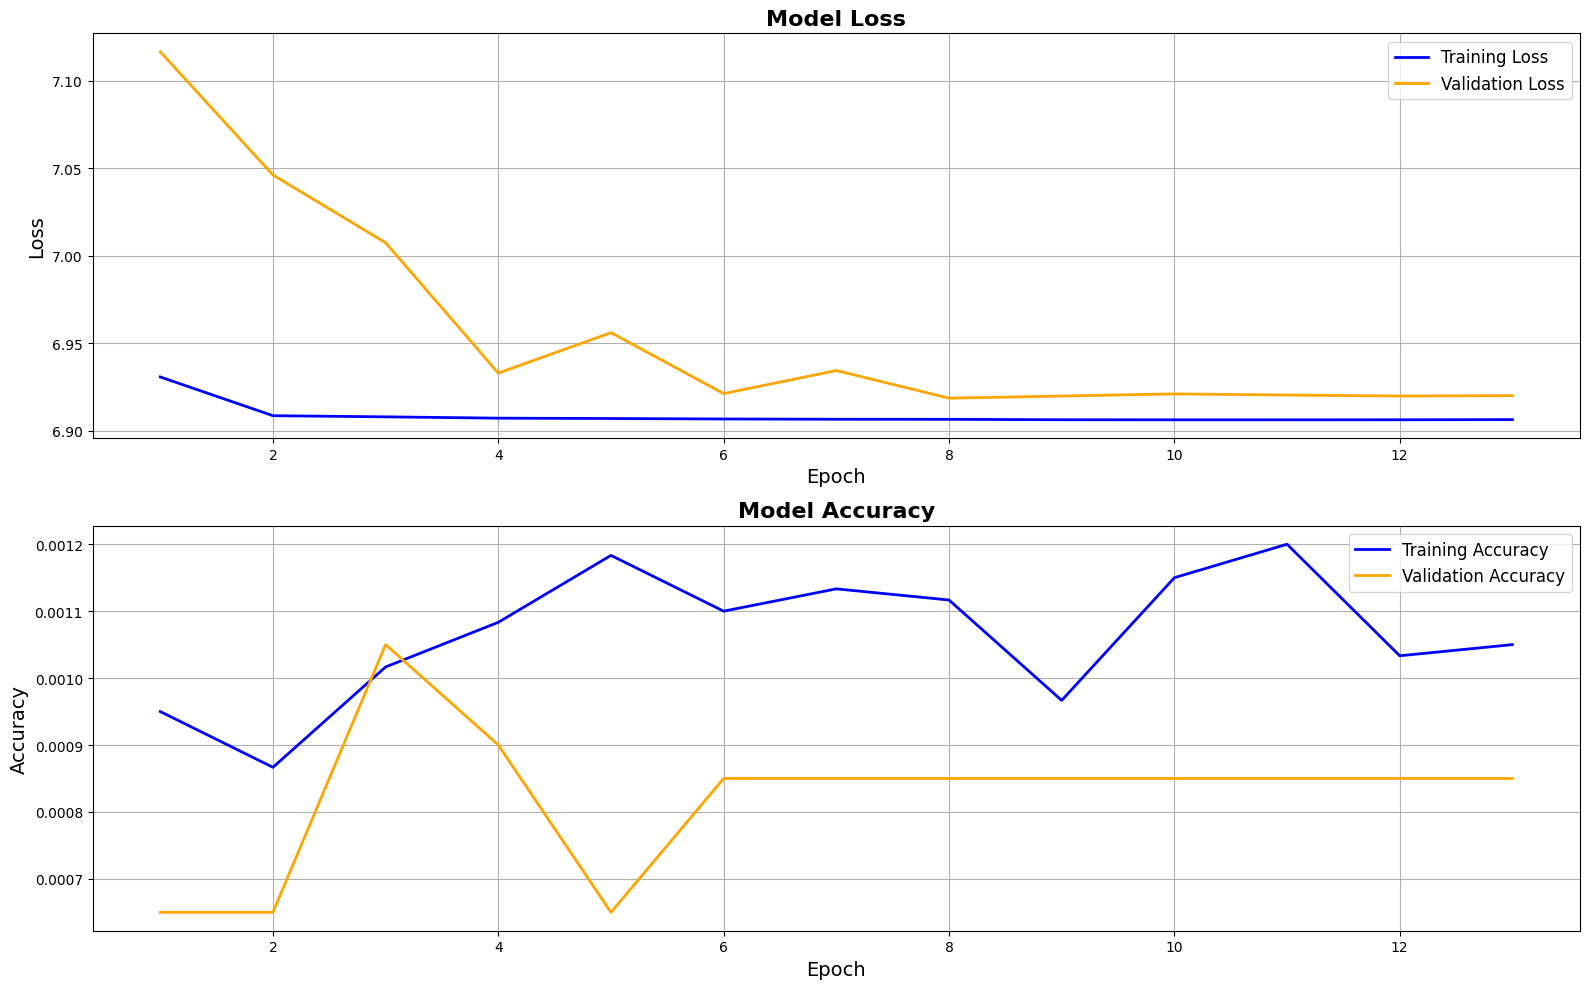

seen labels + 50 epochs

Completed epochs: 50

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


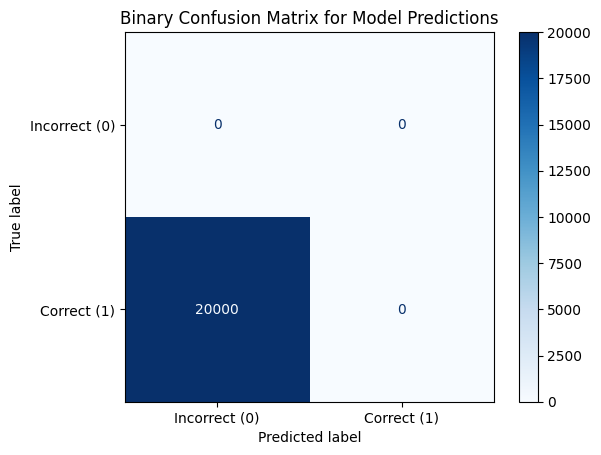

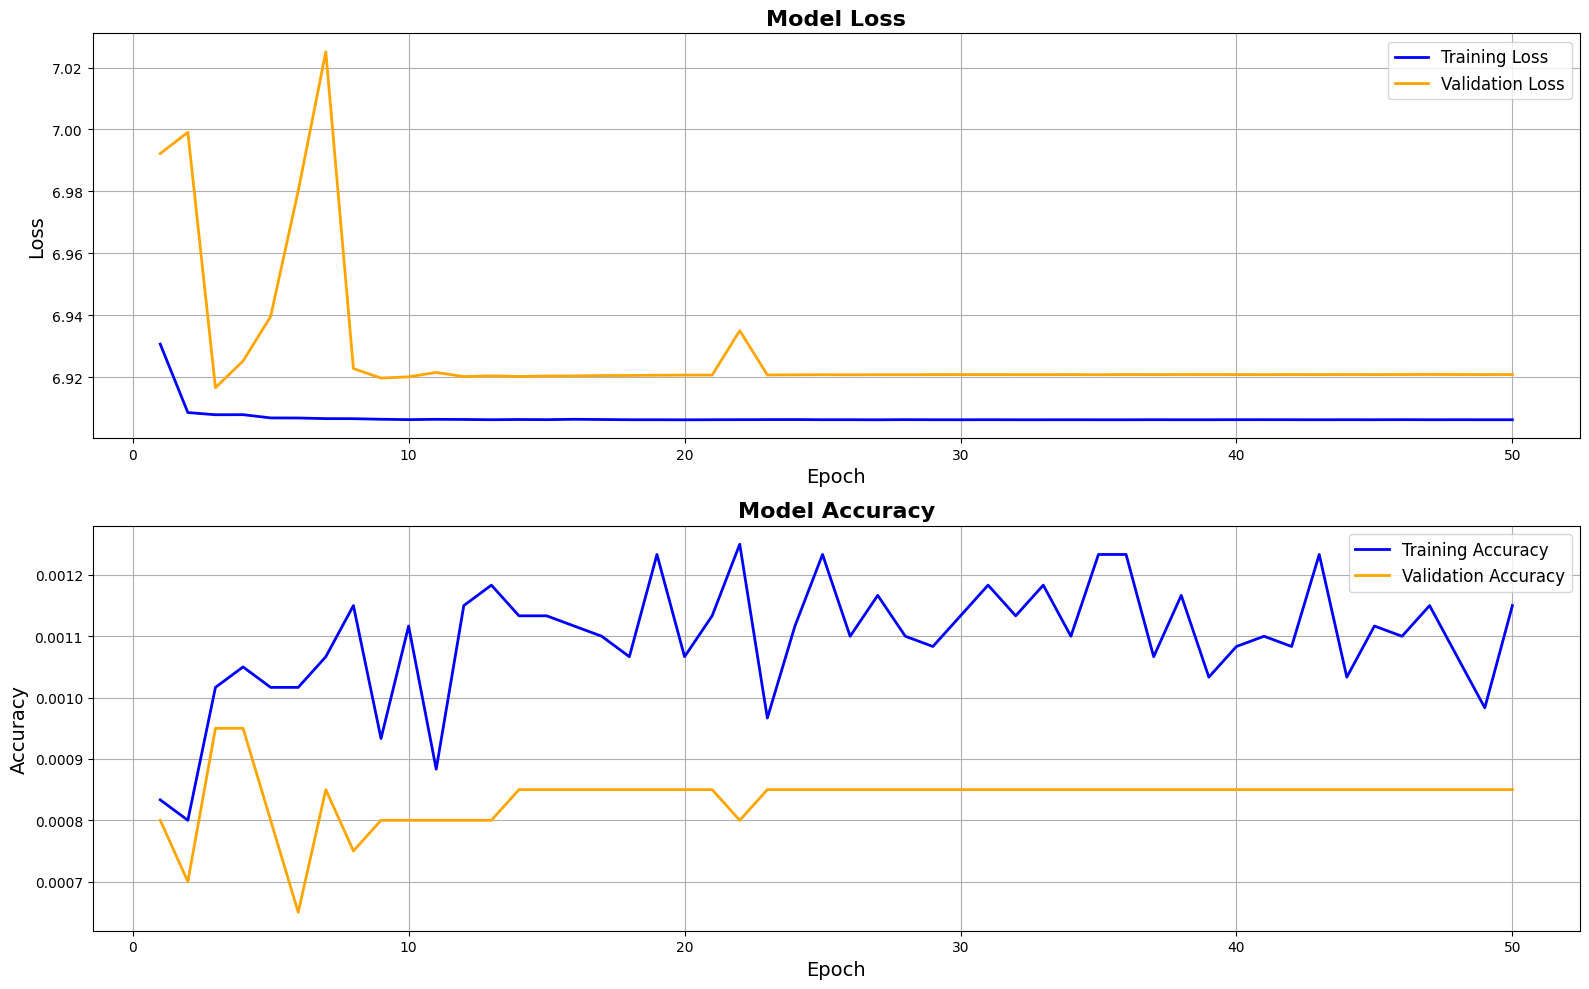

seen labels + 25 epochs

Completed epochs: 25

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


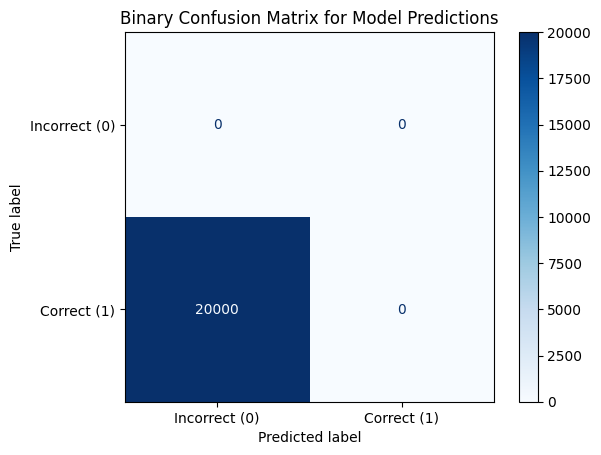

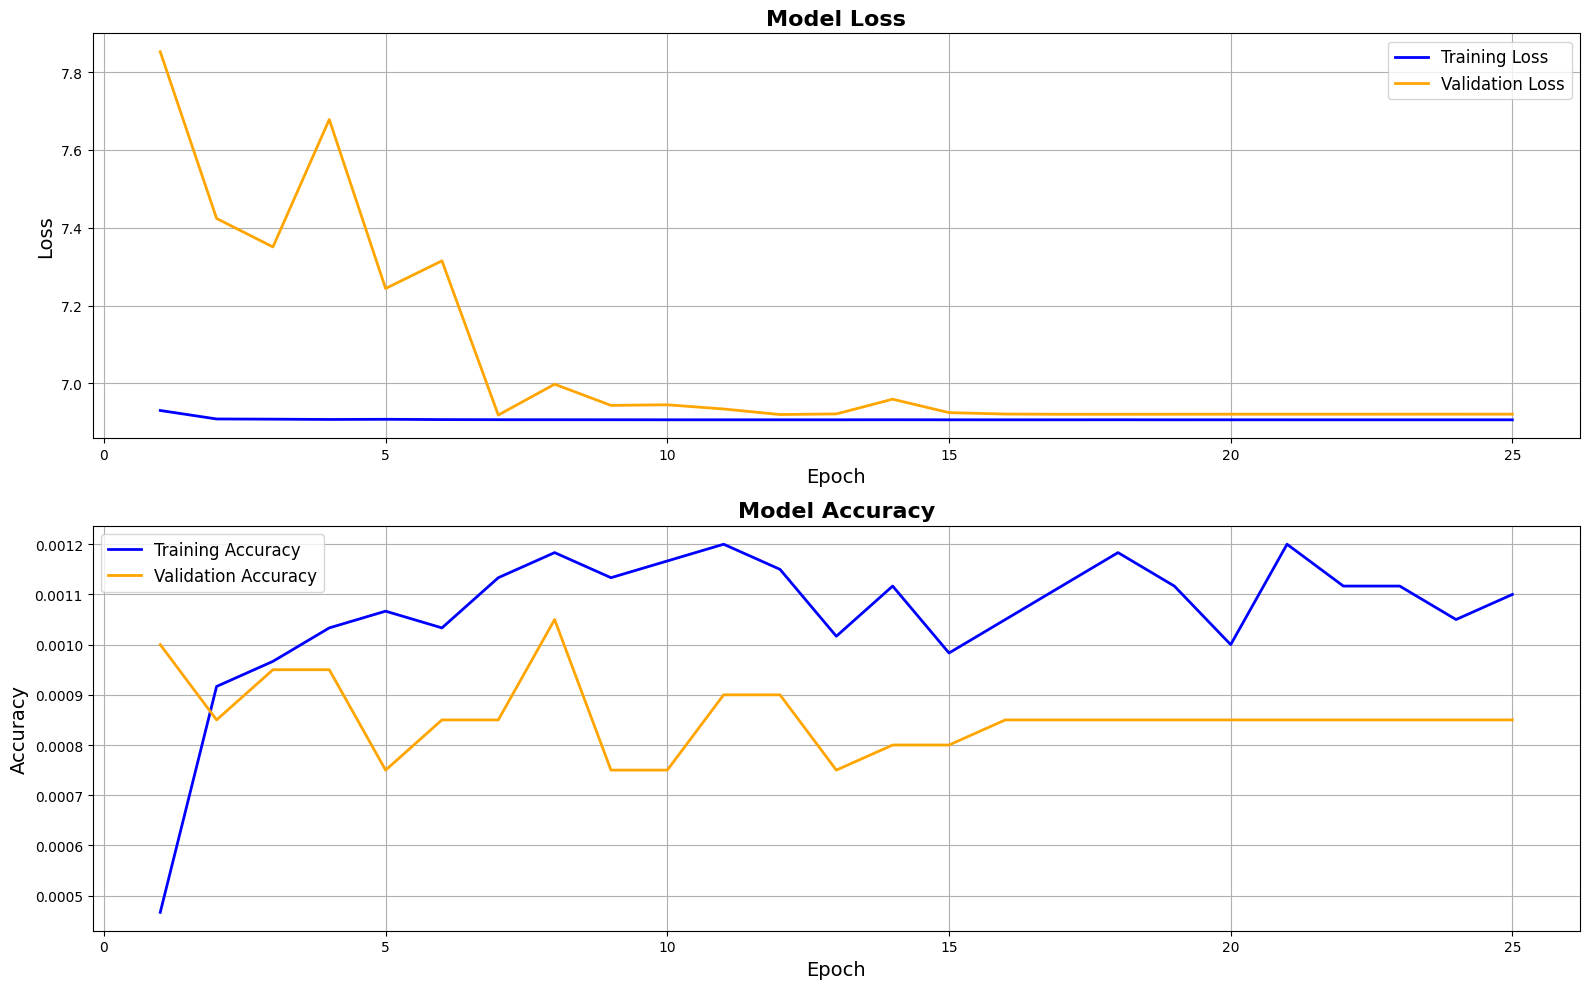

In [55]:
print("\n\ncomplex seen")
print("seen labels + lrs + earlystopping")
get_stat_history(sp_predictions2,sp_test_labels ,sp_history2)
print("seen labels + earlystopping")
get_stat_history(sp_predictions_2,sp_test_labels, sp_history_2)
print("seen labels + 50 epochs")
get_stat_history( sp_predictions__2,sp_test_labels, sp_history__2)
print("seen labels + 25 epochs")
get_stat_history( sp_predictions___2,sp_test_labels,sp_history___2 )


In [56]:
show_label_preds(True, test_imgs, test_labels, predictions1)


<Figure size 2000x2000 with 0 Axes>

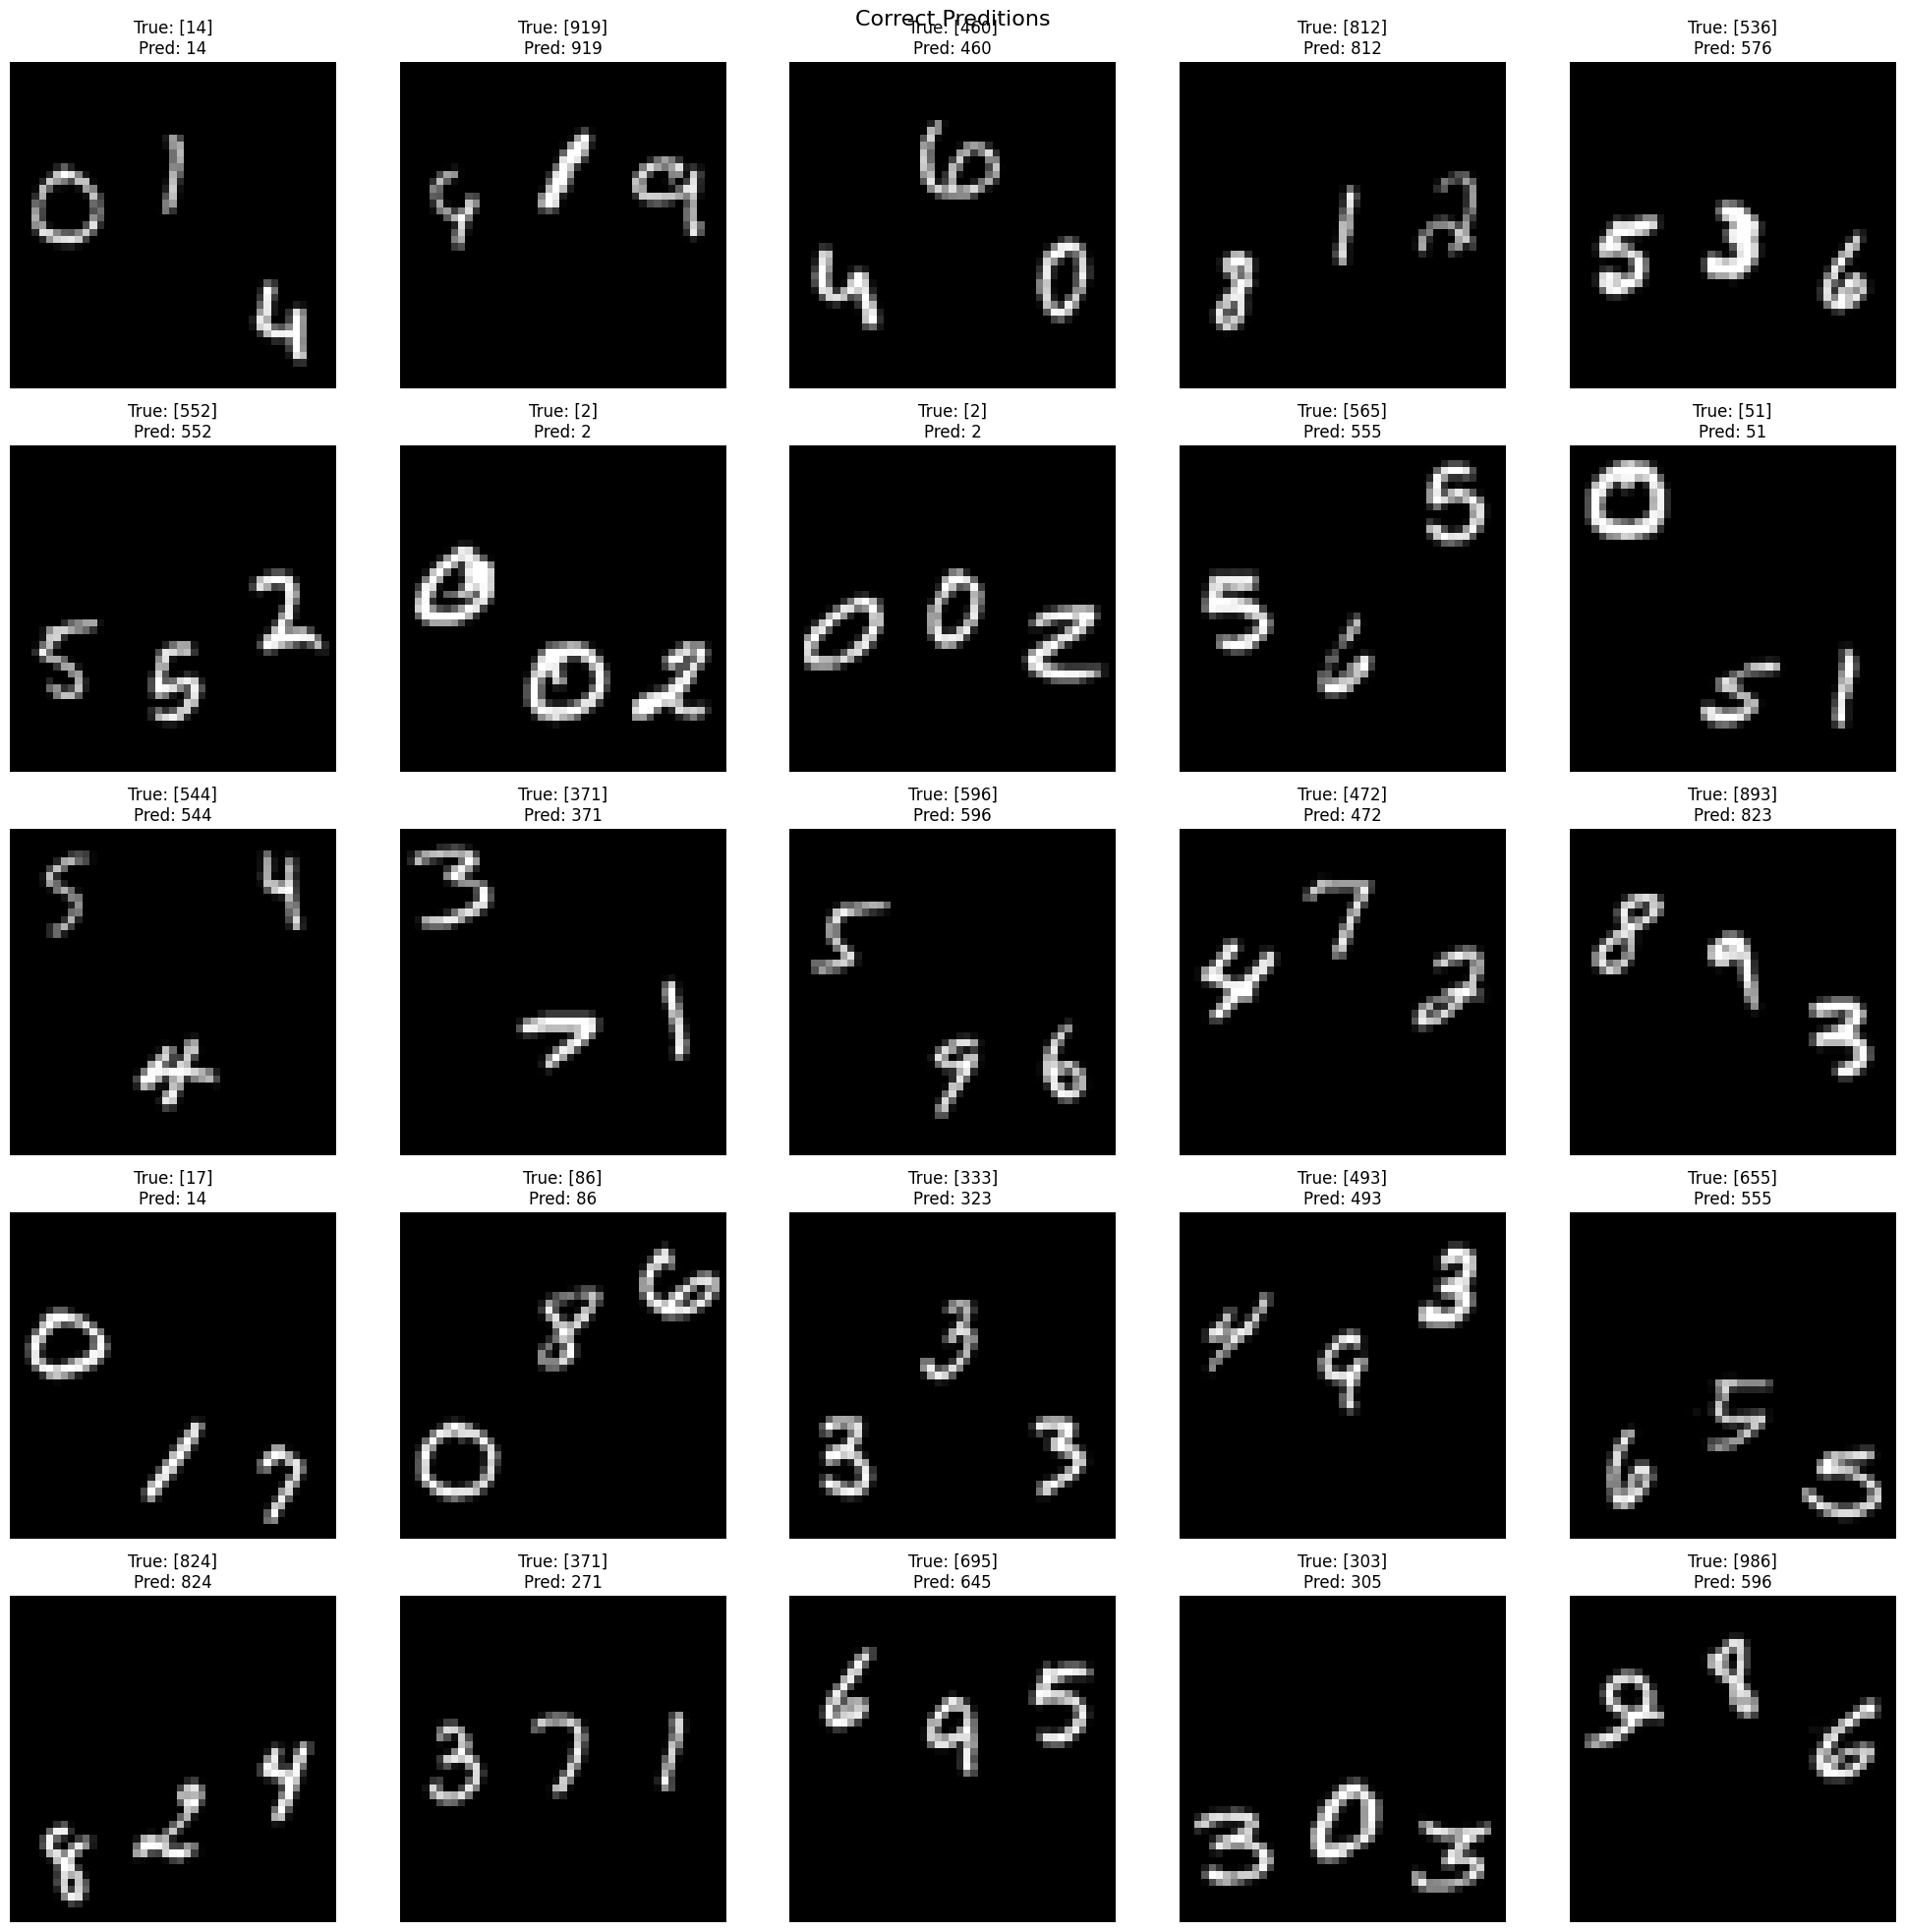

In [57]:
show_label_preds(True, sp_test_imgs, sp_test_labels, sp_predictions1)


SPLIT CNN (see seperate notebook)

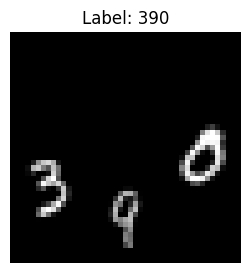

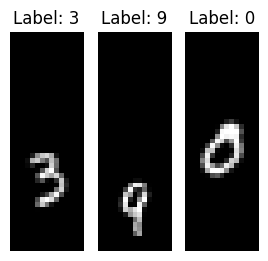

In [124]:
db_set=random.choice(db_sets)

#combine set with db path
set_path=db_path+db_set

#create list of all subfolders in set
sub_folders=os.listdir(set_path)

subfolder=random.choice(sub_folders)
subfolder_path = os.path.join(set_path, subfolder)

#select random image and get pathname
img=random.choice(os.listdir(subfolder_path))
test_img_path=os.path.join(subfolder_path, img)

test_img=Image.open(test_img_path).convert('L').resize((45,45))

split_width = test_img.size[0] // 3

test_splits= [
    test_img.crop((i * split_width, 0 , (i+1) * split_width, test_img.size[1]))
    for i in range(3)
]

# Plot the original image
plt.figure(figsize=(10,3))
plt.imshow(test_img, cmap='gray')
plt.title(f'Label: {subfolder}')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,4))
for i, split in enumerate(test_splits):
    plt.subplot(1, 9, i+1)
    plt.imshow(test_splits[i], cmap='gray')
    plt.title(f'Label: {subfolder[i]}')
    plt.axis('off')
plt.show()


In [9]:
db_path='./triple_mnist/'

def splits_flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            img = Image.open(img_path).convert('L').resize((45,45))
            
            width, height = img.size
            
            split_width = width // 3

            splits = [
                img.crop((i * split_width, 0, (i + 1) * split_width, height))
                for i in range(3)
            ]

            for i, split in enumerate(splits):
                imgs.append(np.array(split))  
                labels.append(int(folder[i]))

    return np.array(imgs), np.array(labels)


t_train_imgs, t_train_labels = splits_flatten_toarray('train')
t_test_imgs, t_test_labels = splits_flatten_toarray('test')
t_val_imgs, t_val_labels = splits_flatten_toarray('val')

t_train_imgs = t_train_imgs / 255.0
t_test_imgs = t_test_imgs / 255.0
t_val_imgs = t_val_imgs / 255.0

In [168]:
print(t_train_imgs.shape)
print(t_train_labels.shape)


(192000, 45, 15, 1)
(192000,)


In [61]:
def t_build_cnn_basic():
    t_model = models.Sequential()
    t_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 15, 1)))
    t_model.add(layers.MaxPooling2D((2, 2)))

    t_model.add(layers.Flatten())
    t_model.add(layers.Dropout(0.5))
    t_model.add(layers.Dense(100, activation='relu'))
    t_model.add(layers.Dense(10, activation='softmax'))

    t_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # compile model
    return t_model

In [62]:
def t_build_cnn_comp():
   # CNN Model Architecture (Adjusted Padding)
    t_model2 = models.Sequential()

    # Conv Layer Block 1
    t_model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(45, 15, 1)))
    t_model2.add(layers.BatchNormalization())
    t_model2.add(layers.MaxPooling2D((2, 2)))
    t_model2.add(layers.Dropout(0.3))

    # Conv Layer Block 2
    t_model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    t_model2.add(layers.BatchNormalization())
    t_model2.add(layers.MaxPooling2D((2, 2)))
    t_model2.add(layers.Dropout(0.3))

    # Conv Layer Block 3
    t_model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    t_model2.add(layers.BatchNormalization())
    t_model2.add(layers.MaxPooling2D((2, 2)))
    t_model2.add(layers.Dropout(0.3))

    # Flatten the output of the last convolutional layer
    t_model2.add(layers.Flatten())

    # Fully Connected (Dense) Layer
    t_model2.add(layers.Dense(512, activation='relu'))
    t_model2.add(layers.Dropout(0.5))

    # Output Layer
    t_model2.add(layers.Dense(10, activation='softmax'))  

   #  model2.summary()
    t_model2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # compile model
    return t_model2

In [63]:
t_train_imgs = t_train_imgs[:, :, :, np.newaxis]
t_val_imgs = t_val_imgs[:, :, :, np.newaxis]
t_test_imgs = t_test_imgs[:, :, :, np.newaxis]

'''
print(f"t_train_imgs shape: {t_train_imgs.shape}")
print(f"t_test_imgs shape: {t_val_imgs.shape}")


print(t_train_labels.shape)
print(t_val_labels.shape)

print(len(t_train_labels))
'''


'\nprint(f"t_train_imgs shape: {t_train_imgs.shape}")\nprint(f"t_test_imgs shape: {t_val_imgs.shape}")\n\n\nprint(t_train_labels.shape)\nprint(t_val_labels.shape)\n\nprint(len(t_train_labels))\n'

In [64]:
t_models = []
histories = []
for i in range(3):
    print(f"Training model for digit {i+1}")
    t_model = t_build_cnn_comp()
    
    t_history = t_model.fit(t_train_imgs[i::3], t_train_labels[i::3], epochs=10,
              validation_data=(t_val_imgs[i::3], t_val_labels[i::3]))
    t_models.append(t_model)
    histories.append(t_history)

Training model for digit 1


Epoch 1/10
2000/2000 [==============================] - 83s 41ms/step - loss: 0.6141 - accuracy: 0.7998 - val_loss: 0.1639 - val_accuracy: 0.9504
Epoch 2/10
2000/2000 [==============================] - 82s 41ms/step - loss: 0.1896 - accuracy: 0.9429 - val_loss: 0.3587 - val_accuracy: 0.9019
Epoch 3/10
2000/2000 [==============================] - 83s 41ms/step - loss: 0.1516 - accuracy: 0.9546 - val_loss: 0.6071 - val_accuracy: 0.8542
Epoch 4/10
2000/2000 [==============================] - 83s 42ms/step - loss: 0.1298 - accuracy: 0.9614 - val_loss: 0.0633 - val_accuracy: 0.9803
Epoch 5/10
2000/2000 [==============================] - 84s 42ms/step - loss: 0.1160 - accuracy: 0.9660 - val_loss: 0.1174 - val_accuracy: 0.9644
Epoch 6/10
2000/2000 [==============================] - 84s 42ms/step - loss: 0.1034 - accuracy: 0.9694 - val_loss: 0.0660 - val_accuracy: 0.9801
Epoch 7/10
2000/2000 [==============================] - 84s 42ms/step - loss: 0.0973 - accuracy: 0.9715 - val_loss: 0.0573 -

In [65]:
predictions = []
for i, model in enumerate(t_models):
    preds = np.argmax(model.predict(t_test_imgs[i::3]), axis=1)
    predictions.append(preds)

all_preds = np.array(predictions).T

625/625 [==============================] - 8s 12ms/step


In [66]:
# Combine true labels into a single array for comparison
test_labels_combined = np.array([int(str(label).zfill(3)) for label in t_test_labels])
predicted_labels_combined = np.array([int("".join(map(str, pred))) for pred in all_preds])

# Metrics
accuracy = accuracy_score(test_labels, predicted_labels_combined)
f1 = f1_score(test_labels, predicted_labels_combined, average='macro')
conf_matrix = confusion_matrix(test_labels, predicted_labels_combined)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
# print("Confusion Matrix:")
# print(conf_matrix)


Accuracy: 0.9555
F1 Score: 0.3466


In [67]:
print(test_labels_combined.shape)
print(predicted_labels_combined.shape)

(60000,)
(20000,)


Test loss: [0.04546104 0.03743898 0.0706638 ]
Test accuracy: [0.98615003 0.98904997 0.9795    ]
Accuracy: 0.9555
F1 Score (Macro Average): 0.3466


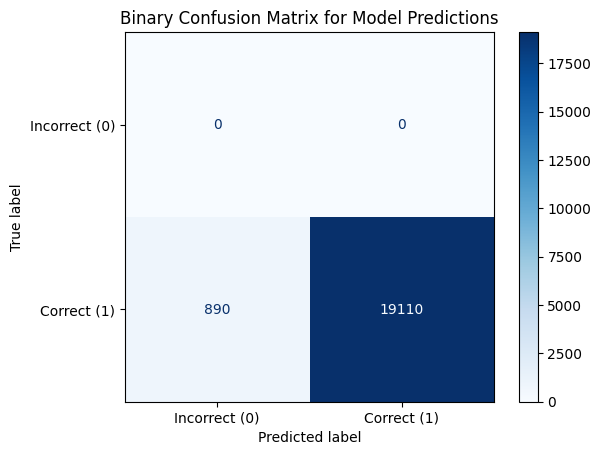

In [68]:
evals = []
for i, model in enumerate(t_models):
    eval = model.evaluate(t_test_imgs[i::3], t_test_labels[i::3], verbose=0)
    evals.append(eval)

score = np.array(evals).T

print("Test loss:", score[0])
print("Test accuracy:", score[1])


# Correctly predicted = 1, Incorrectly predicted = 0
binary_predictions = (predicted_labels_combined == test_labels).astype(int)

# True binary labels
binary_true_labels = np.ones_like(binary_predictions)  # True labels are all "correct" (1)

# Compute confusion matrix
conf_matrix = confusion_matrix(binary_true_labels, binary_predictions, labels=[0, 1])

# Compute accuracy
accuracy = accuracy_score(test_labels, predicted_labels_combined)

# Compute F1 Score (macro-average across classes)
f1 = f1_score(test_labels, predicted_labels_combined, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro Average): {f1:.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Incorrect (0)', 'Correct (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Binary Confusion Matrix for Model Predictions')
plt.show()


GAN experimentation (see seperate notebooks also)

In [69]:
reshaped_labels = t_test_labels.reshape(-1, 3)

comb_test_labels = np.array([int("".join(map(str, group))) for group in reshaped_labels])

print(comb_test_labels.shape)


(20000,)


In [70]:
print(t_test_imgs.shape)
print(t_test_labels.shape)

print(t_train_imgs.shape)
print(t_train_labels.shape)

t_train_imgs_reshaped = t_train_imgs.reshape(192000, 675)
print(t_train_imgs_reshaped.shape)

nt_train_imgs = (t_train_imgs - 0.5) / 0.5  # Normalize to [-1, 1] range for GAN

nt_train_imgs_re = nt_train_imgs.reshape(192000, 675)

print(nt_train_imgs.shape)



(60000, 45, 15, 1)
(60000,)
(192000, 45, 15, 1)
(192000,)
(192000, 675)
(192000, 45, 15, 1)


In [221]:
print(train_imgs.shape)

n_train_imgs= (train_imgs - 0.5) / 0.5
n_train_imgs= train_imgs.reshape(64000, 2025)

print(n_train_imgs.shape)

(64000, 84, 84)
(64000, 2025)


In [10]:
# Reshape the labels to (64000, 3) by splitting into groups of 3
rs_t_train_labels = t_train_labels.reshape(64000, 3)
rs_f_train_imgs = tf.convert_to_tensor(f_train_imgs)


# Print the result to verify
print(rs_t_train_labels.shape)  # Should output (64000, 3)

# rs_f_train_imgs = tf.expand_dims(rs_f_train_imgs, axis=-1)

(64000, 3)


In [6]:
print(rs_f_train_imgs.shape)

(64000, 84, 84)


In [11]:
rs_f_train_imgs = tf.reshape(rs_f_train_imgs, (64000, 84, 84, 1))


In [8]:
print(rs_f_train_imgs.shape)

(64000, 84, 84, 1)


In [236]:
splits = tf.split(rs_f_train_imgs, num_or_size_splits=3, axis=2)

In [12]:
def generate_and_visualize(generator, latent_dim, num_images=16):
    noise = tf.random.normal([num_images, latent_dim])
    generated_images = generator(noise)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]
    
    # Visualize
    plt.figure(figsize=(4, 4))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()


In [132]:
# NO LABELS
def build_generator(z_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=z_dim),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(84 * 84 * 1, activation='tanh'), #SHAPE
        layers.Reshape((84, 84, 1)) #SHAPE

    ])
    return model


def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(84,84,1)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential([generator, discriminator])
    return model

In [13]:
def build_generator():
    # Label embedding
    label_embedding = layers.Embedding(10, 16, name="label_embedding")

    # Label projection
    label_proj = layers.Dense(128 * 6 * 6, name="label_proj")

    # Noise projection
    noise_proj = layers.Dense(256 * 6 * 6, name="noise_proj")

    # Convolutional blocks
    conv_blocks = tf.keras.Sequential([
        # First Conv2DTranspose layer
        layers.Conv2DTranspose(128, kernel_size=2, strides=7, padding='same', use_bias=False, input_shape=(384, 6, 6), data_format='channels_first'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        # Second Conv2DTranspose layer
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False, data_format='channels_first'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        
        # Fourth Conv2DTranspose layer
        layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', use_bias=False, data_format='channels_first'),
        layers.Activation('tanh')
    ])

    # conv_blocks.summary()

    # Forward pass
    def generator(noise, labels):
        labels=labels[:noise.shape[0]]

        print(f"\nGenerator Forward Pass:")
        print(f"Input noise shape: {noise.shape}")
        print(f"Input labels shape: {labels.shape}")


        # Embed and project labels
        emb1 = label_embedding(labels[:, 0])
        emb2 = label_embedding(labels[:, 1])
        emb3 = label_embedding(labels[:, 2])
        
        emb_cat = tf.concat([emb1, emb2, emb3], axis=1)  # Concatenate embeddings

        print(f"Combined label embeddings shape: {emb_cat.shape}")


        label_feat = label_proj(emb_cat)  # Project labels
        label_feat = tf.reshape(label_feat, (-1, 128, 6, 6))  # Reshape

        
        # Project and reshape noise
        noise_feat = noise_proj(noise)
        noise_feat = tf.reshape(noise_feat, (-1, 256, 6, 6))  # Reshape

        print(f"Projected noise shape: {noise_feat.shape}")
        print(f"Projected label shape: {label_feat.shape}")


        # Combine noise and label features
        combined = tf.concat([noise_feat, label_feat], axis=1)

        print(f"Combined features shape: {combined.shape}")


        # Apply convolutional blocks
        output = conv_blocks(combined)

        output = tf.reshape(output, (-1, 84, 84, 1))

        print(f"Final output shape: {output.shape}")


        return output

    return generator




In [1]:
def build_discriminator(dropout_rate=0.3):
    # Label embeddings
    label_embedding_1 = layers.Embedding(10, 16, name="label_embedding_1")
    label_embedding_2 = layers.Embedding(10, 16, name="label_embedding_2")
    label_embedding_3 = layers.Embedding(10, 16, name="label_embedding_3")
    
    # Label projections
    label_proj_blocks = [
        tf.keras.Sequential([
            layers.Dense(64, name=f"label_proj_dense_{i}"),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2)
        ], name=f"label_proj_{i}") for i in range(1, 4)
    ]
    
    # Convolutional blocks
    conv_blocks = tf.keras.Sequential([
        # First conv block
        layers.Conv2D(32, kernel_size=4, strides=2, padding="same", input_shape=(84, 84, 1)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(dropout_rate),
        
        # Second conv block
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(dropout_rate),
        
        # Third conv block
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(dropout_rate),
        
        # Flatten
        layers.Flatten()
    ], name="conv_blocks")
    
    # Output blocks
    digit_classifier = tf.keras.Sequential([
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(dropout_rate),
        layers.Dense(10)
    ], name="digit_classifier")
    
    adversarial = tf.keras.Sequential([
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation="sigmoid")
    ], name="adversarial")
    
    def discriminator(img, labels):        
        # Process labels - handle each label separately
        emb1 = label_embedding_1(labels[:,0])
        emb2 = label_embedding_2(labels[:,1])
        emb3 = label_embedding_3(labels[:,2])
        
        # Process each embedding
        feat1 = label_proj_blocks[0](emb1)
        feat2 = label_proj_blocks[1](emb2)
        feat3 = label_proj_blocks[2](emb3)
        
        # Combine label features
        label_feat = tf.concat([feat1, feat2, feat3], axis=1)
        
        # Process image
        conv_feat = conv_blocks(img)
        
        # Generate outputs
        digit_preds = digit_classifier(conv_feat)
        combined_features = tf.concat([conv_feat, label_feat], axis=1)
        validity = adversarial(combined_features)
        
        return tf.squeeze(validity), digit_preds
    
    return discriminator


In [12]:
def old_train_gan(generator, discriminator, gan, train_images, latent_dim, epochs, batch_size, display_interval):

    for epoch in range(epochs):
        # Train discriminator
        real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]
        real_labels = np.ones((batch_size, 1))
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        # Print losses for each epoch
        print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]*100:.2f}%, G Loss: {g_loss:.4f}")

        if epoch % 25 == 0:
            generate_and_visualize(generator, latent_dim)



In [247]:
'''
# Hyperparameters
latent_dim = 128  # Size of the noise vector
batch_size = 32
epochs = 250
display_interval = 1000

noise = np.random.normal(0, 1, (batch_size, latent_dim))

generator = (build_generator(latent_dim))(noise, rs_t_train_labels)

# generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])


validity, preds_stack = (build_discriminator())(rs_f_train_imgs, rs_t_train_labels)

# discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

'''


Generator Forward Pass:
Input noise shape: (32, 128)
Input labels shape: (32, 3)
Combined label embeddings shape: (32, 48)
Projected noise shape: (32, 256, 6, 6)
Projected label shape: (32, 128, 6, 6)
Combined features shape: (32, 384, 6, 6)
Final output shape: (32, 6144, 96, 1)
Combined label embeddings shape: (64000, 64)
split length : 3
Combined features shape: (64000, 28288)
Final output shape: (64000, 1)


In [15]:
def build_gan(generator, discriminator, latent_dim):
    # Create the input tensors for the GAN
    noise_input = layers.Input(shape=(latent_dim,), name="noise_input")
    label_input = layers.Input(shape=(3,), dtype=tf.int32, name="label_input")
    
    # Generate fake images using the generator
    fake_images = generator(noise_input, label_input)
    print("\n")

    # Set the discriminator's input to the generated images and labels
    validity, _ = discriminator(fake_images, label_input)  # Only care about validity (real/fake)
    
    # Create the GAN model (takes noise and labels as input, outputs validity)
    gan = tf.keras.Model(inputs=[noise_input, label_input], outputs=validity, name="gan_model")
    
    return gan

In [2]:
latent_dim = 128  # Size of the noise vector
batch_size = 32
epochs = 250
display_interval = 1000

# Define the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Build the GAN
gan = build_gan(generator, discriminator, latent_dim)

# Compile the GAN
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')


NameError: name 'build_generator' is not defined

In [21]:
def train_gan(generator, discriminator, gan, train_images, train_labels, latent_dim, epochs, batch_size, display_interval=25):

    # Batch iteration
    for epoch in range(epochs):
        # Train the discriminator on real and fake images
        real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]
        real_labels = train_labels[np.random.randint(0, train_labels.shape[0], batch_size)]

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict([noise, real_labels])
        fake_labels = np.zeros((batch_size, 1))  # Fake images labeled as 0 (fake)
        real_labels_ = np.ones((batch_size, 1))  # Real images labeled as 1 (real)
        
        # Train the discriminator on real images
        d_loss_real = discriminator.train_on_batch(real_images, [real_labels_, real_labels_])
        
        # Train the discriminator on fake images
        d_loss_fake = discriminator.train_on_batch(fake_images, [fake_labels, fake_labels])
        
        # Average discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator via the GAN model (generator tries to fool discriminator)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch([noise, real_labels], real_labels_)  # We want the discriminator to classify fake as real
        
        # Print losses for each epoch
        print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]*100:.2f}%, G Loss: {g_loss:.4f}")
        
        # Optionally display generated images every 'display_interval' epochs
        if epoch % display_interval == 0:
            generate_and_visualize(generator, latent_dim)

# Helper function to visualize generated images
def generate_and_visualize(generator, latent_dim):
    noise = np.random.normal(0, 1, (16, latent_dim))  # Generate 16 random noise vectors
    labels = np.random.randint(0, 10, (16, 3))  # Random labels for the generated images
    generated_images = generator.predict([noise, labels])

    # Rescale images to [0, 255] for display
    generated_images = (generated_images + 1) * 127.5
    generated_images = np.clip(generated_images, 0, 255).astype(np.uint8)

    # Plot the generated images
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(4, 4, figsize=(5, 5))
    axs = axs.ravel()
    
    for i in range(16):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
    
    plt.show()


In [22]:
# Example setup
latent_dim = 128  # Latent space dimension
batch_size = 64  # Size of each training batch
epochs = 250  # Number of epochs to train
display_interval = 25  # Display generated images every x epochs


noise = np.random.normal(0, 1, (batch_size, latent_dim))
label_input = rs_t_train_labels


input_noise = tf.keras.Input(shape=(latent_dim,), name="noise_input")
input_labels = tf.keras.Input(shape=(3,), name="label_input")
input_imgs = tf.keras.Input(shape=(84, 84, 1), name="image_input")

fake_imgs = generator(input_noise, label_input)
validity, _ = discriminator(rs_f_train_imgs, label_input)

validity, digit_preds = discriminator(input_imgs, input_labels)

# Generate the model by calling the function
generator_model = tf.keras.Model(inputs=[input_imgs, input_labels], outputs=fake_imgs, name="generator")
discriminator_model = tf.keras.Model(inputs=[f_train_imgs, label_input], outputs=[validity, _], name="discriminator")

# Train the GAN
train_gan(generator_model, discriminator_model, gan, f_train_imgs, rs_t_train_labels, latent_dim, epochs, batch_size, display_interval)


Generator Forward Pass:
Input noise shape: (None, 128)
Input labels shape: (64000, 3)
Combined label embeddings shape: (64000, 48)
Projected noise shape: (None, 256, 6, 6)
Projected label shape: (64000, 128, 6, 6)
Combined features shape: (64000, 384, 6, 6)
Final output shape: (64000, 84, 84, 1)


: 

In [ ]:
old_train_gan(generator, discriminator, gan, f_train_imgs, latent_dim, epochs, batch_size, display_interval)

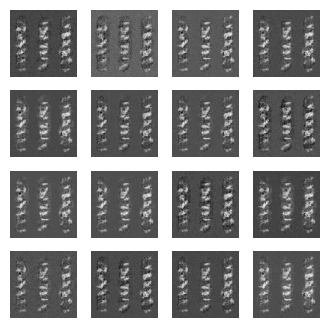

In [139]:
generate_and_visualize(generator, latent_dim)
